## `Modules imports`

In [1]:
%%time

#Data Preprocessing and data Visualization modules:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack

#General purpose modules:
import sys
import os
import re
import time
import warnings
import math
import datetime
from collections import Counter, defaultdict, namedtuple
from zipfile import ZipFile

#NLP Modules:
from nltk.corpus import stopwords
import spacy
import string


#Machine Learning Modules:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, normalized_mutual_info_score
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#!pip install imblearn
#!pip install mlxtend

from mlxtend.classifier import StackingClassifier
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")
%matplotlib inline

start = time.time()

/home/reachjalesh_gmail_com/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


CPU times: user 1.87 s, sys: 500 ms, total: 2.37 s
Wall time: 17.3 s


## `Loading Data`

In [2]:
data = pd.read_csv('training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4

In [3]:
# note the seprator in this file
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


ID                                               TEXT
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...

## `Stopwords and Basic Preprocessing`

In [4]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

## `NULL values checks`

In [5]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 34.381276 seconds


## `Merging Dataframes`

In [6]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                TEXT  
0  cyclin dependent kinases cdks regulate variety...  
1  abstract background non small cell lung cancer...  
2  abstract background non small cell lung cancer...  
3  recent evidence demonstrated acquired uniparen...  
4  oncogenic mutations monomeric casitas b lineag...

## `Null Value replacement`

In [7]:
result[result.isnull().any(axis=1)]

ID    Gene             Variation  Class TEXT
1109  1109   FANCA                S1088F      1  NaN
1277  1277  ARID5B  Truncating Mutations      1  NaN
1407  1407   FGFR3                 K508M      6  NaN
1639  1639    FLT1         Amplification      6  NaN
2755  2755    BRAF                 G596C      7  NaN

In [7]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [8]:
result[result['ID']==1109]

ID   Gene Variation  Class          TEXT
1109  1109  FANCA    S1088F      1  FANCA S1088F

## `Train Test split`

In [10]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [11]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


## `Confusion matrix function`

In [10]:
def plot_confusion_matrix(test_y, predict_y):
    
    ''' This function plots the confusion matrices given y_i, y_i_hat.'''
    
    C = confusion_matrix(test_y, predict_y)    
    A =(((C.T)/(C.sum(axis=1))).T)   
    B =(C/C.sum(axis=0))    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

## `Confusion matrix for test data`

Log loss on Cross Validation Data using Random Model 2.4936582165215695
Log loss on Test Data using Random Model 2.4772567205812805
-------------------- Confusion matrix --------------------


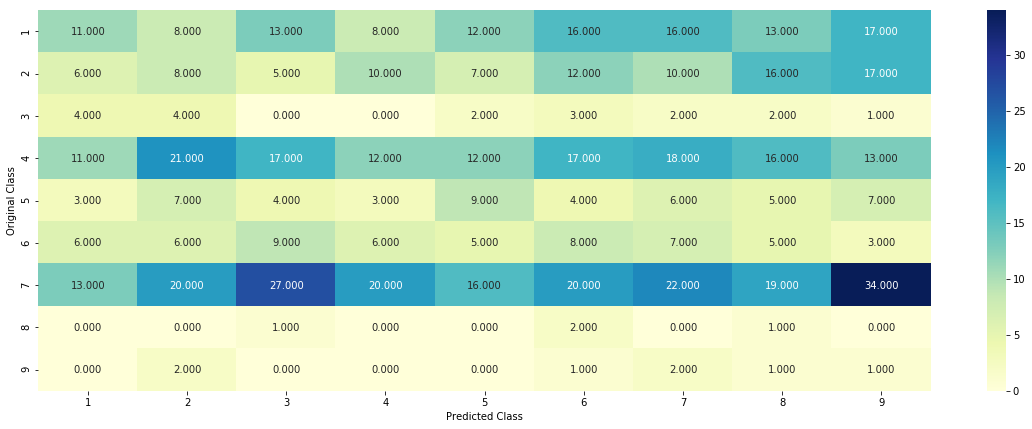

-------------------- Precision matrix (Columm Sum=1) --------------------


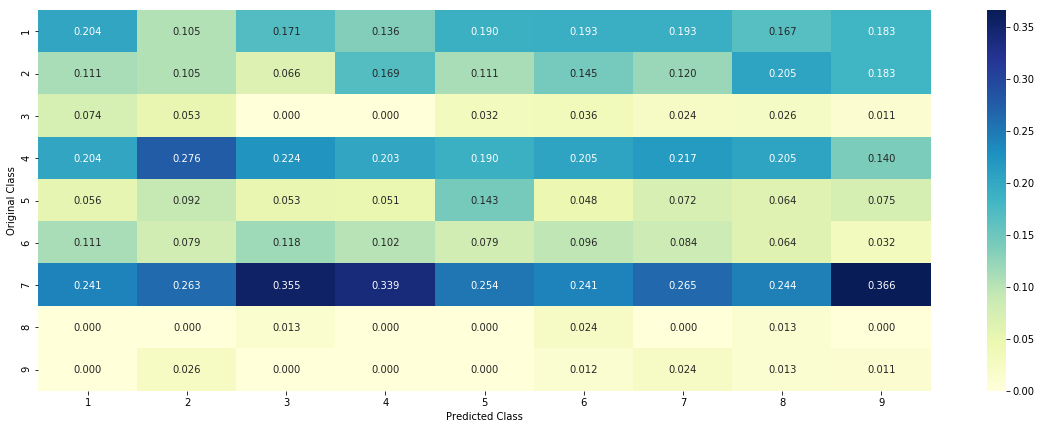

-------------------- Recall matrix (Row sum=1) --------------------


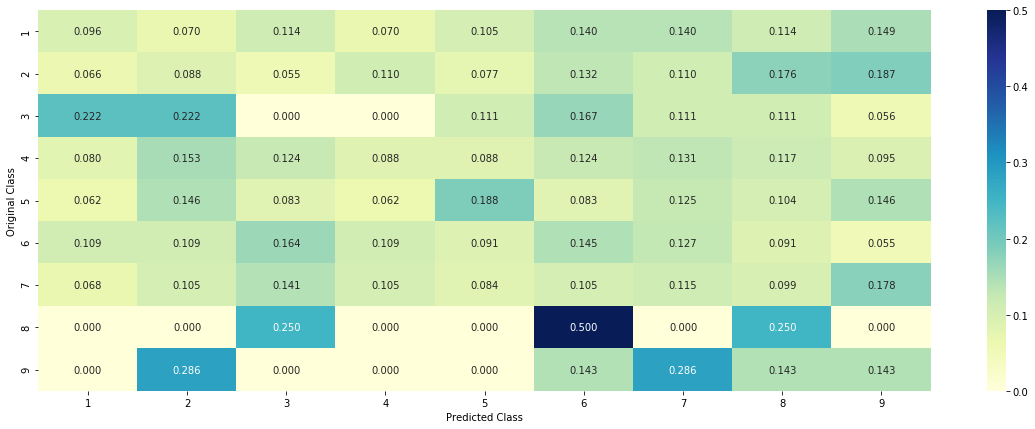

In [13]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

## `Response Coding Function`

In [11]:
def get_gv_fea_dict(alpha, feature, df):
    
    '''  code for response coding with Laplace smoothing. '''
    
    value_count = train_df[feature].value_counts()  
    gv_dict = dict()   
    for i, denominator in value_count.items():        
        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):    
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()    
    gv_fea = []
    
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [15]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 233
BRCA1     166
TP53      101
EGFR       88
BRCA2      84
PTEN       71
KIT        67
BRAF       54
ERBB2      43
ALK        40
PIK3CA     40
Name: Gene, dtype: int64


In [16]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

Ans: There are 233 different categories of genes in the train data, and they are distibuted as follows


## `Univariate Analysis- "Genes" feature`

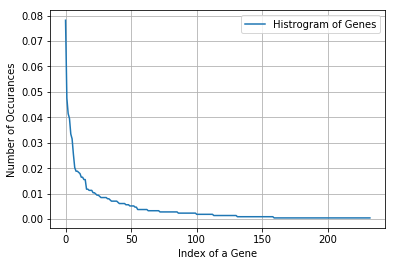

In [17]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

### `CDF of "Genes" feature`

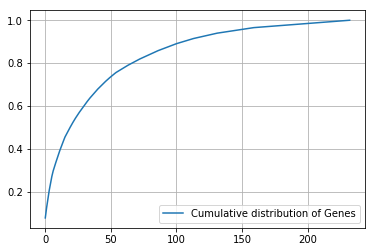

In [18]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

### `response-coding of the Gene feature`

In [17]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [20]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


### `one-hot encoding of Gene feature`

In [21]:
gene_vectorizer = TfidfVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [22]:
gene_vectorizer.get_feature_names()[1:20]

['acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'asxl2',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'b2m']

In [23]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 232)


## `Random Model based off "Genes" feature`

For values of alpha =  1e-05 The log loss is: 1.2251299939940758
For values of alpha =  0.0001 The log loss is: 1.214662597103067
For values of alpha =  0.001 The log loss is: 1.2681960246464927
For values of alpha =  0.01 The log loss is: 1.3710366282258921
For values of alpha =  0.1 The log loss is: 1.4429160266958456
For values of alpha =  1 The log loss is: 1.4748511895947871


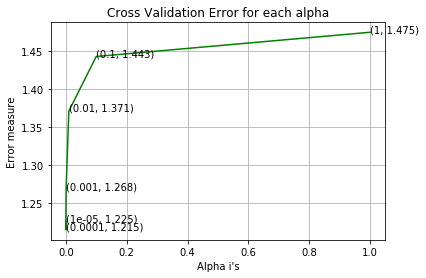

For values of best alpha =  0.0001 The train log loss is: 0.9814876593077615
For values of best alpha =  0.0001 The cross validation log loss is: 1.214662597103067
For values of best alpha =  0.0001 The test log loss is: 1.1953834608249165
CPU times: user 3.2 s, sys: 260 ms, total: 3.46 s
Wall time: 2.97 s


In [24]:
%%time

alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


### `features distribution similarity`

In [25]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  233  genes in train dataset?
Ans
1. In test data 642 out of 665 : 96.54135338345866
2. In cross validation data 519 out of  532 : 97.55639097744361


In [26]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1934
Truncating_Mutations    59
Deletion                50
Amplification           38
Fusions                 22
Overexpression           4
T58I                     3
ETV6-NTRK3_Fusion        2
Q61H                     2
M1R                      2
T167A                    2
Name: Variation, dtype: int64


In [27]:
print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)

Ans: There are 1934 different categories of variations in the train data, and they are distibuted as follows


### `Univariate Analysis: "Variations" feature`

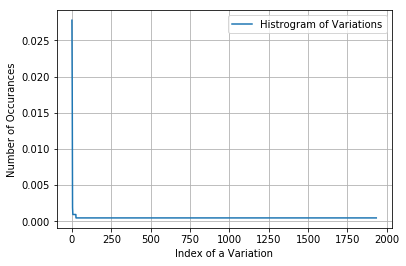

In [28]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02777778 0.05131827 0.06920904 ... 0.99905838 0.99952919 1.        ]


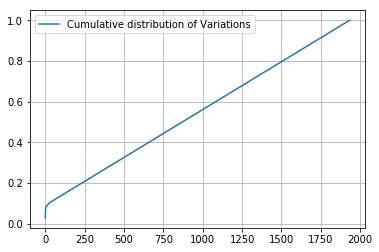

In [29]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

### `ResponseCoding-"Variations" feature`

In [30]:
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [31]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


## `one-hot encoding of variation feature.`

In [32]:
variation_vectorizer = TfidfVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

## `RANDOM model based off "variation" feature`

For values of alpha =  1e-05 The log loss is: 1.7259516630690905
For values of alpha =  0.0001 The log loss is: 1.7202774282138014
For values of alpha =  0.001 The log loss is: 1.7187359641802025
For values of alpha =  0.01 The log loss is: 1.7247948721537107
For values of alpha =  0.1 The log loss is: 1.7377416958621612
For values of alpha =  1 The log loss is: 1.7399571355411245


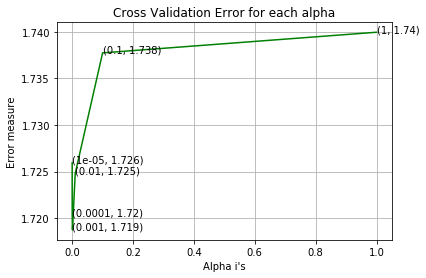

For values of best alpha =  0.001 The train log loss is: 1.0358852784578676
For values of best alpha =  0.001 The cross validation log loss is: 1.7187359641802025
For values of best alpha =  0.001 The test log loss is: 1.712431319815166
CPU times: user 2.78 s, sys: 276 ms, total: 3.06 s
Wall time: 2.57 s


In [33]:
%%time

alpha = [10 ** x for x in range(-5, 1)]


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


## `Data overlapping ratio of Train, CV, test`

In [34]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total  1934  genes in test and cross validation data sets?
Ans
1. In test data 72 out of 665 : 10.827067669172932
2. In cross validation data 59 out of  532 : 11.090225563909774


## `response coding functions`

In [35]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [36]:
import math
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

## `TF-idf Vectorizer`

In [37]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))

print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 54296


In [38]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

## `Normalization of response coding and TFidf vectors`

In [39]:
%%time

#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T


# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)


CPU times: user 3min 41s, sys: 48 ms, total: 3min 41s
Wall time: 3min 41s


In [40]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [41]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({0.006719085158031594: 320, 0.012024541397599484: 316, 0.04355963712171015: 237, 0.011326925683575883: 226, 0.07231610794761875: 201, 0.021884971326663262: 159, 0.362596916493673: 151, 0.02669931019632396: 140, 0.07124729747458287: 128, 0.23403399981896733: 127, 0.01692270587208794: 125, 0.01478966844429467: 122, 0.04160777012677566: 119, 0.019350783800489168: 115, 0.05794292934180964: 109, 0.046855051027832176: 106, 0.045259207421379934: 105, 0.009393134944771377: 104, 0.02973936501997352: 101, 0.10024657334300907: 100, 0.027168413233554872: 96, 0.047485910800563975: 95, 0.01886130423393728: 91, 0.11927191026818011: 87, 0.02193676054054093: 86, 0.033580886174706316: 86, 0.019974160148450566: 84, 0.02518850772384988: 82, 0.012228499736251135: 82, 0.04437371144553691: 82, 0.025052647066361986: 78, 0.011392661193667624: 77, 0.01629255138964133: 75, 0.028600119254726393: 71, 0.034602101462320706: 70, 0.03694284939378377: 70, 0.015488536559535571: 67, 0.049553241256507716: 67, 0.05

## `LR-TFidf using "Text" feature`

For values of alpha =  1e-05 The log loss is: 1.338035174558428
For values of alpha =  0.0001 The log loss is: 1.2085015079002037
For values of alpha =  0.001 The log loss is: 1.219579559095129
For values of alpha =  0.01 The log loss is: 1.314945294649905
For values of alpha =  0.1 The log loss is: 1.3573777466634829
For values of alpha =  1 The log loss is: 1.5905157797794824


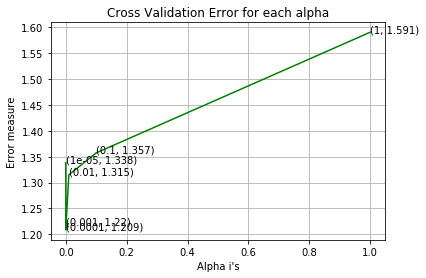

For values of best alpha =  0.0001 The train log loss is: 0.5927172241940076
For values of best alpha =  0.0001 The cross validation log loss is: 1.2085015079002037
For values of best alpha =  0.0001 The test log loss is: 1.063214701351022
CPU times: user 2min 54s, sys: 1min 11s, total: 4min 5s
Wall time: 1min 53s


In [42]:
%%time

alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


## `data overlapping ratio of train, cv and test`

In [43]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [44]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

96.671 % of word of test data appeared in train data
98.034 % of word of Cross Validation appeared in train data


## `ML models common functions`

In [45]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [46]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [47]:
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec =  TfidfVectorizer()
    var_count_vec  =  TfidfVectorizer()
    text_count_vec =  TfidfVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

# `Stacking up various encoded arrays`

In [48]:
%%time

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


CPU times: user 332 ms, sys: 44 ms, total: 376 ms
Wall time: 373 ms


In [49]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 56491)
(number of data points * number of features) in test data =  (665, 56491)
(number of data points * number of features) in cross validation data = (532, 56491)


In [50]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


# `NB TFidf`

for alpha = 1e-05
Log Loss : 1.341221633756921
for alpha = 0.0001
Log Loss : 1.340905581948691
for alpha = 0.001
Log Loss : 1.3362898161029808
for alpha = 0.1
Log Loss : 1.322043858642515
for alpha = 1
Log Loss : 1.2878396249438373
for alpha = 10
Log Loss : 1.3683837141130493
for alpha = 100
Log Loss : 1.3409160511051308
for alpha = 1000
Log Loss : 1.281028464449732


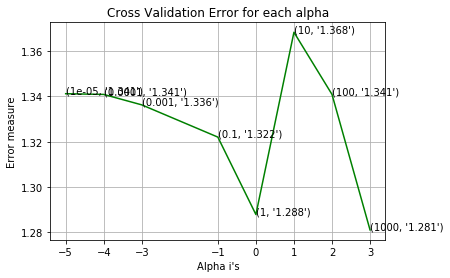

For values of best alpha =  1000 The train log loss is: 0.9081154344328944
For values of best alpha =  1000 The cross validation log loss is: 1.281028464449732
For values of best alpha =  1000 The test log loss is: 1.1549839664523562
CPU times: user 7.4 s, sys: 292 ms, total: 7.69 s
Wall time: 7.2 s


In [51]:
%%time

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


# `Optimal NB-TFidf model`

Log Loss : 1.281028464449732
Number of missclassified point : 0.41353383458646614
-------------------- Confusion matrix --------------------


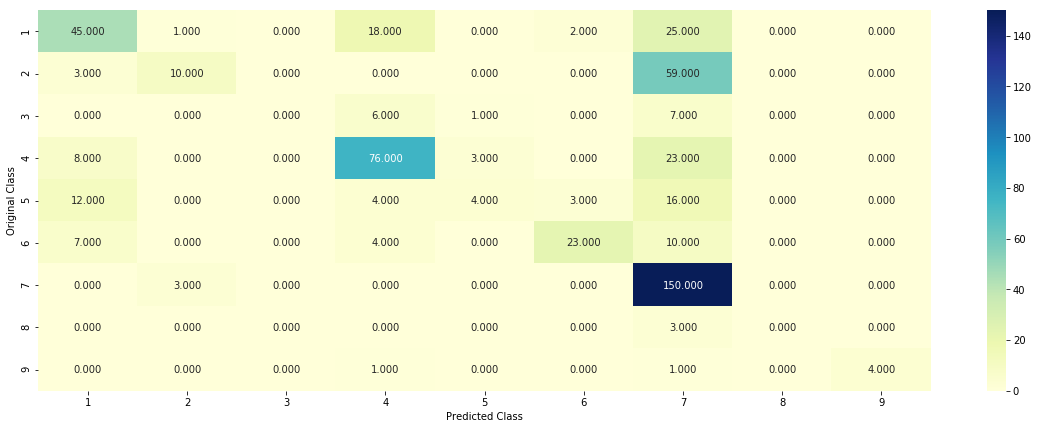

-------------------- Precision matrix (Columm Sum=1) --------------------


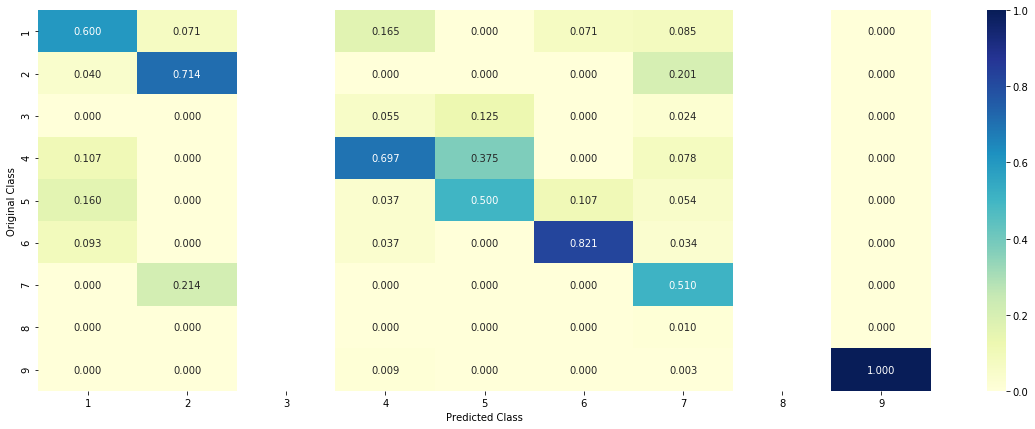

-------------------- Recall matrix (Row sum=1) --------------------


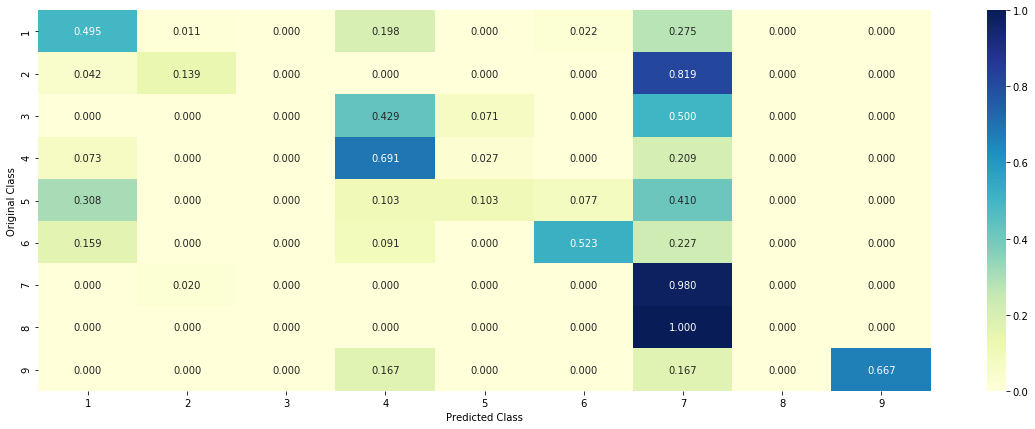

In [52]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

# `KNN-TFidf`

for alpha = 5
Log Loss : 1.13393777630271
for alpha = 11
Log Loss : 1.1175963090059697
for alpha = 15
Log Loss : 1.1233117791812288
for alpha = 21
Log Loss : 1.1269250430395947
for alpha = 31
Log Loss : 1.139355423252588
for alpha = 41
Log Loss : 1.1459178603323292
for alpha = 51
Log Loss : 1.1575942750279777
for alpha = 99
Log Loss : 1.1742620614919874


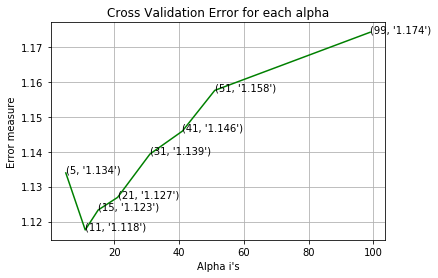

For values of best alpha =  11 The train log loss is: 0.612834639539372
For values of best alpha =  11 The cross validation log loss is: 1.1175963090059697
For values of best alpha =  11 The test log loss is: 1.0707118314851032
CPU times: user 4.1 s, sys: 276 ms, total: 4.38 s
Wall time: 3.96 s


In [54]:
%%time
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


## `Optimal KNN-TFidf model`

Log loss : 1.1175963090059697
Number of mis-classified points : 0.39097744360902253
-------------------- Confusion matrix --------------------


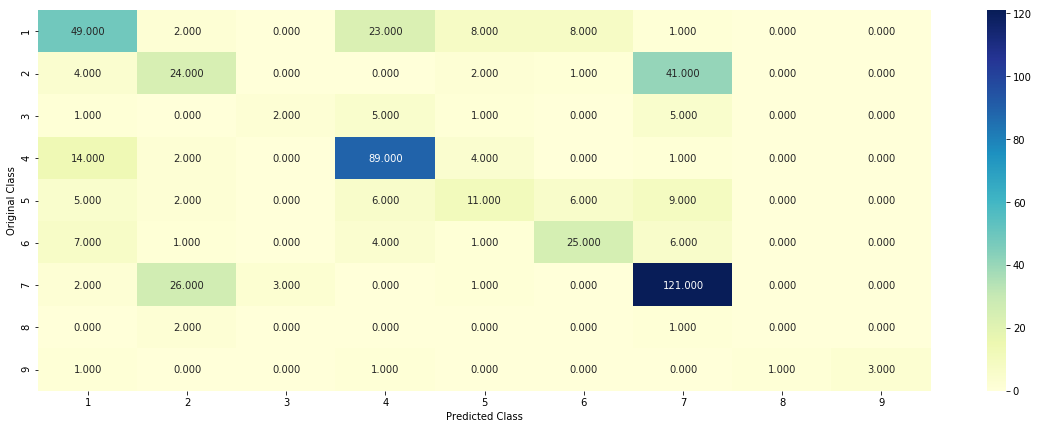

-------------------- Precision matrix (Columm Sum=1) --------------------


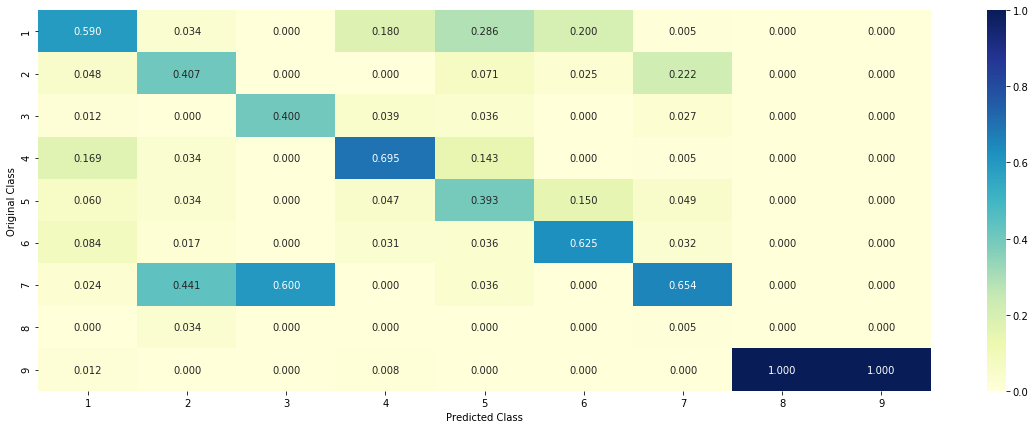

-------------------- Recall matrix (Row sum=1) --------------------


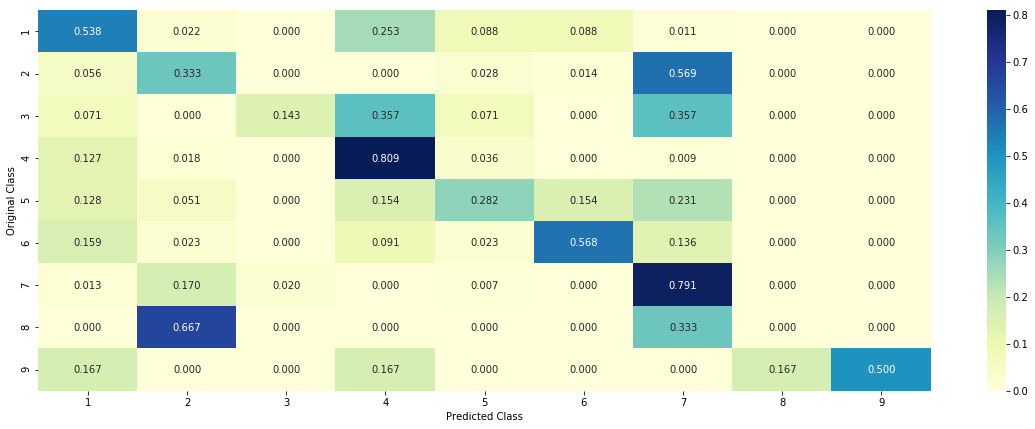

CPU times: user 4.12 s, sys: 1.58 s, total: 5.7 s
Wall time: 2.71 s


In [55]:
%%time
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

# `sample Query pt 1`

In [56]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 4
The  11  nearest neighbours of the test points belongs to classes [1 1 1 1 1 1 1 1 4 1 4]
Fequency of nearest points : Counter({1: 9, 4: 2})


# `LR-TFidf with class balancing`

for alpha = 1e-06
Log Loss : 1.3436129589779984
for alpha = 1e-05
Log Loss : 1.292021490397198
for alpha = 0.0001
Log Loss : 1.1607309575648206
for alpha = 0.001
Log Loss : 1.1663737717723806
for alpha = 0.01
Log Loss : 1.2417815091172042
for alpha = 0.1
Log Loss : 1.2767147157701633
for alpha = 1
Log Loss : 1.4398426163149851
for alpha = 10
Log Loss : 1.4778544243869374
for alpha = 100
Log Loss : 1.4821177553860203


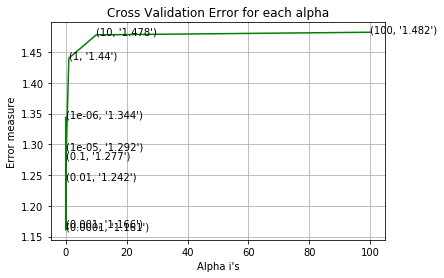

For values of best alpha =  0.0001 The train log loss is: 0.44372387993321616
For values of best alpha =  0.0001 The cross validation log loss is: 1.1607309575648206
For values of best alpha =  0.0001 The test log loss is: 1.012420933476503
CPU times: user 3min 29s, sys: 1min 40s, total: 5min 10s
Wall time: 2min 2s


In [57]:
%%time

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

## `Optimal LR-TFidf (with class balancing)Model`

Log loss : 1.1607309575648206
Number of mis-classified points : 0.37406015037593987
-------------------- Confusion matrix --------------------


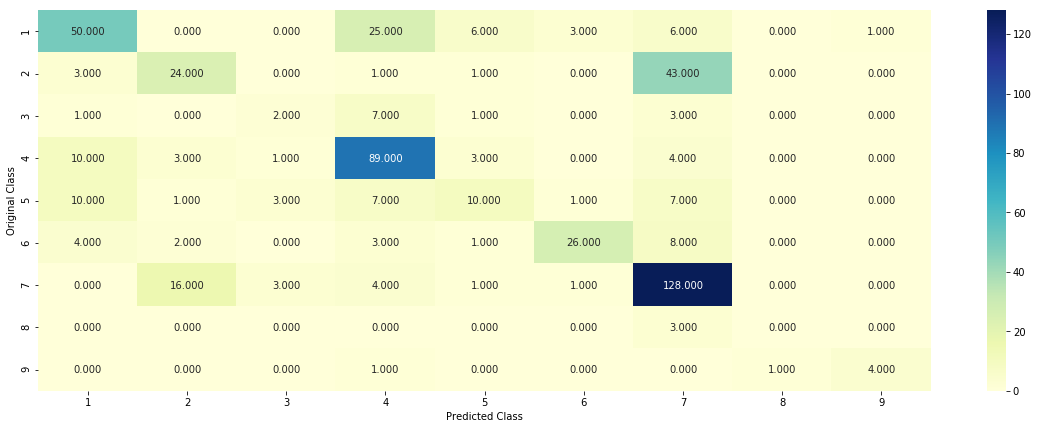

-------------------- Precision matrix (Columm Sum=1) --------------------


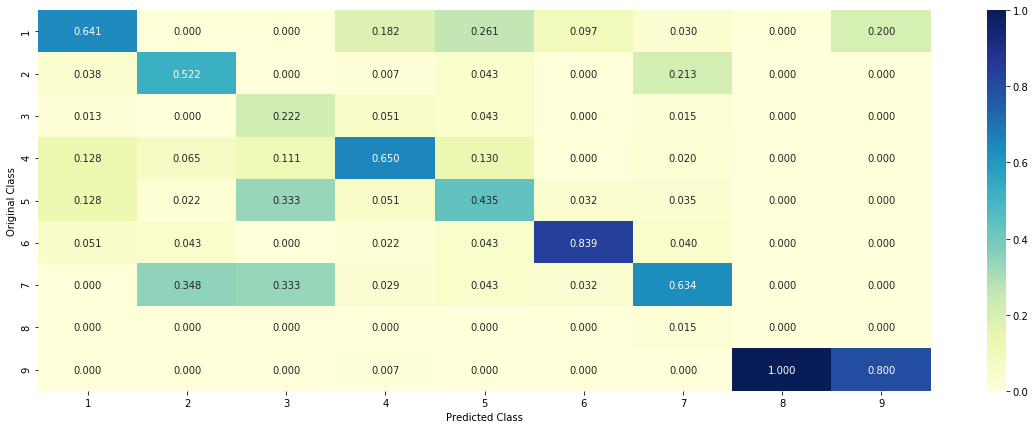

-------------------- Recall matrix (Row sum=1) --------------------


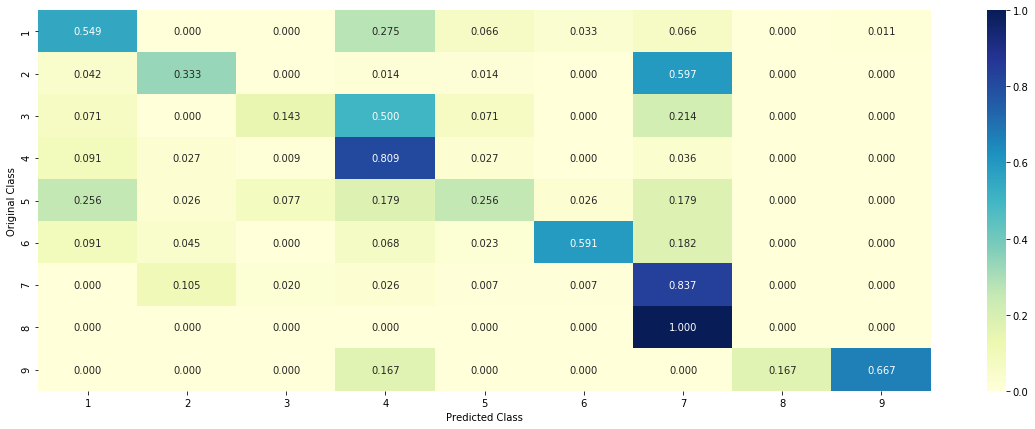

In [58]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### `FI(with class balancing)`

In [59]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [60]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.8248 0.0236 0.0041 0.0782 0.0044 0.0057 0.0467 0.0068 0.0058]]
Actual Class : 4
--------------------------------------------------
306 Text feature [fanca] present in test data point [True]
347 Text feature [valuable] present in test data point [True]
371 Text feature [brdurd] present in test data point [True]
389 Text feature [mv1lu] present in test data point [True]
409 Text feature [slug] present in test data point [True]
Out of the top  500  features  5 are present in query point


#### ` FI (Without Class balancing)`

for alpha = 1e-06
Log Loss : 1.3166265879495334
for alpha = 1e-05
Log Loss : 1.3068011673432751
for alpha = 0.0001
Log Loss : 1.2005243115594557
for alpha = 0.001
Log Loss : 1.1815916794471715
for alpha = 0.01
Log Loss : 1.2742595319949863
for alpha = 0.1
Log Loss : 1.3187262348572037
for alpha = 1
Log Loss : 1.5241075676129905


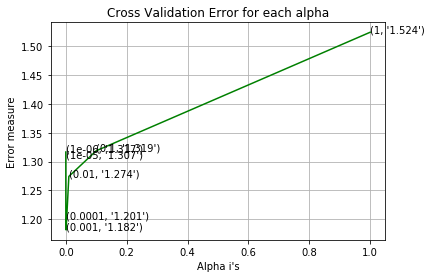

For values of best alpha =  0.001 The train log loss is: 0.46977297531316853
For values of best alpha =  0.001 The cross validation log loss is: 1.1815916794471715
For values of best alpha =  0.001 The test log loss is: 1.0098662645038765
CPU times: user 2min 53s, sys: 1min 20s, total: 4min 13s
Wall time: 1min 43s


In [61]:
%%time
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

## `LR-TFidf (without class balncing)Optimal model`

Log loss : 1.1815916794471715
Number of mis-classified points : 0.37593984962406013
-------------------- Confusion matrix --------------------


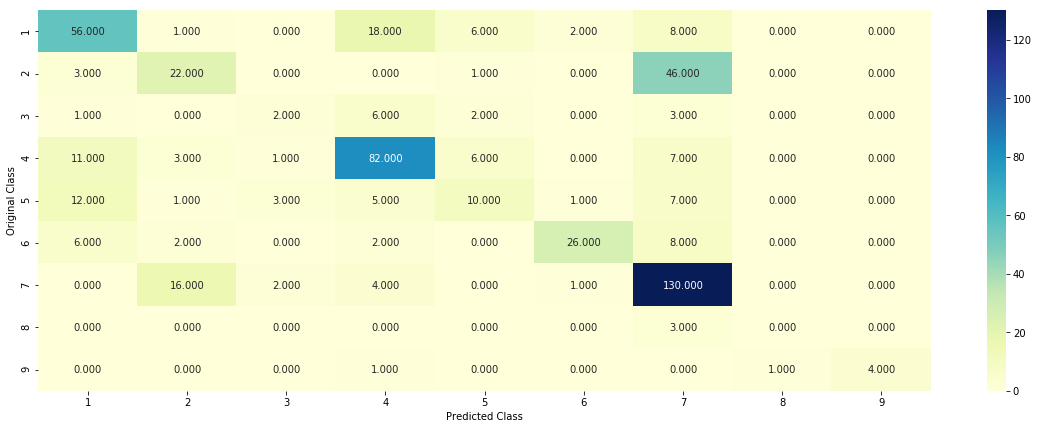

-------------------- Precision matrix (Columm Sum=1) --------------------


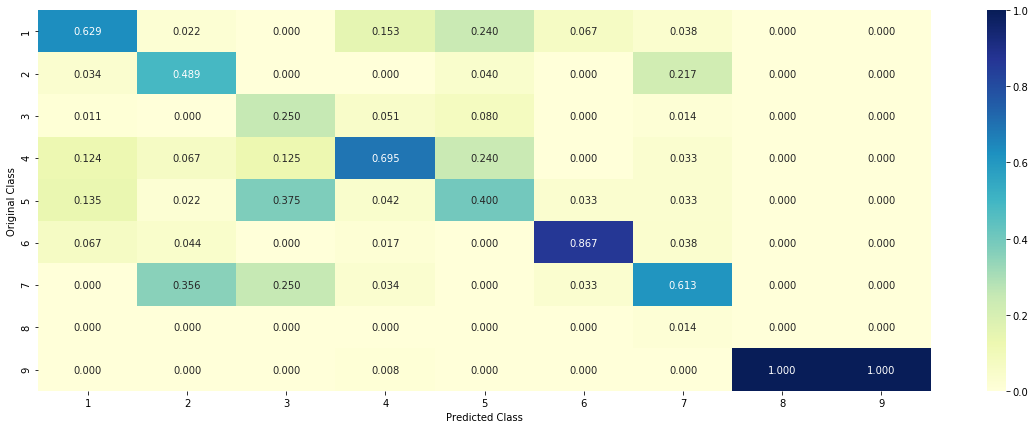

-------------------- Recall matrix (Row sum=1) --------------------


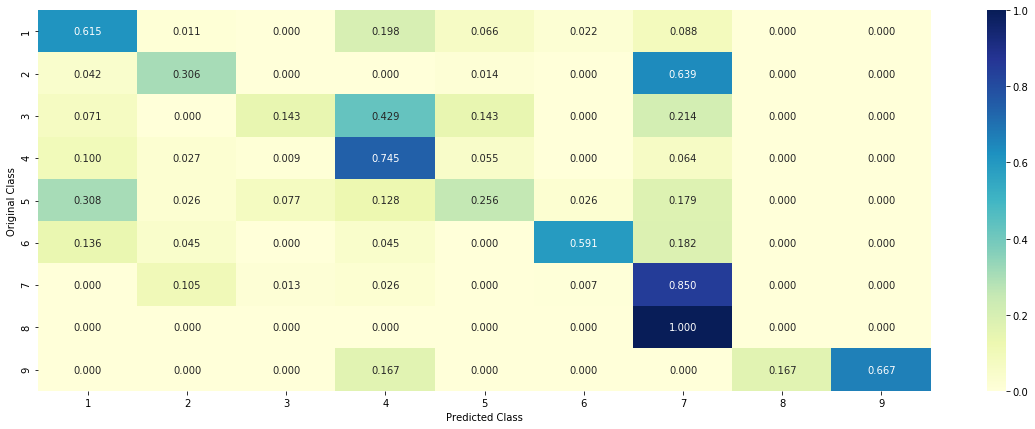

In [62]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### `FI(Correctly Classified point)`

In [63]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[8.175e-01 1.480e-02 6.000e-04 1.065e-01 3.300e-03 4.400e-03 4.680e-02
  5.900e-03 3.000e-04]]
Actual Class : 4
--------------------------------------------------
157 Text feature [kinase] present in test data point [True]
232 Text feature [constitutively] present in test data point [True]
237 Text feature [expressing] present in test data point [True]
260 Text feature [slug] present in test data point [True]
273 Text feature [active] present in test data point [True]
281 Text feature [activated] present in test data point [True]
291 Text feature [phosphorylation] present in test data point [True]
300 Text feature [mv1lu] present in test data point [True]
329 Text feature [activating] present in test data point [True]
330 Text feature [alongside] present in test data point [True]
346 Text feature [contrast] present in test data point [True]
370 Text feature [inhibitors] present in test data point [True]
371 Text feature [inhibited] pr

#### `FI(Inorrectly Classified point)`

In [64]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.7833 0.0149 0.0019 0.1541 0.0094 0.0054 0.027  0.0032 0.001 ]]
Actual Class : 1
--------------------------------------------------
131 Text feature [mounting] present in test data point [True]
232 Text feature [constitutively] present in test data point [True]
237 Text feature [expressing] present in test data point [True]
242 Text feature [abrogating] present in test data point [True]
263 Text feature [e7] present in test data point [True]
273 Text feature [active] present in test data point [True]
281 Text feature [activated] present in test data point [True]
291 Text feature [phosphorylation] present in test data point [True]
346 Text feature [contrast] present in test data point [True]
371 Text feature [inhibited] present in test data point [True]
388 Text feature [stably] present in test data point [True]
415 Text feature [express] present in test data point [True]
470 Text feature [led] present in test data point [True]
483 T

# `Linear SVM-TFidf`

for C = 1e-05
Log Loss : 1.33780293355027
for C = 0.0001
Log Loss : 1.2564842262407092
for C = 0.001
Log Loss : 1.2111557791989287
for C = 0.01
Log Loss : 1.2597158181860728
for C = 0.1
Log Loss : 1.3130092210719857
for C = 1
Log Loss : 1.4833328215033537
for C = 10
Log Loss : 1.4828154863736214
for C = 100
Log Loss : 1.4828161064577585


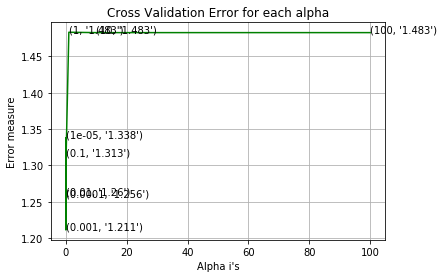

For values of best alpha =  0.001 The train log loss is: 0.5076603216928018
For values of best alpha =  0.001 The cross validation log loss is: 1.2111557791989287
For values of best alpha =  0.001 The test log loss is: 1.0638200572129506


In [65]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

## `Optimal SVM-TFidf model`

Log loss : 1.2111557791989287
Number of mis-classified points : 0.37781954887218044
-------------------- Confusion matrix --------------------


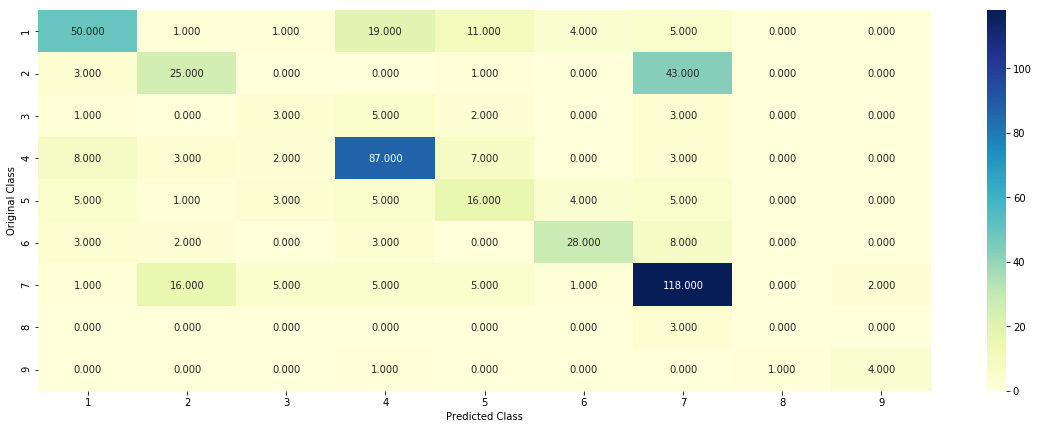

-------------------- Precision matrix (Columm Sum=1) --------------------


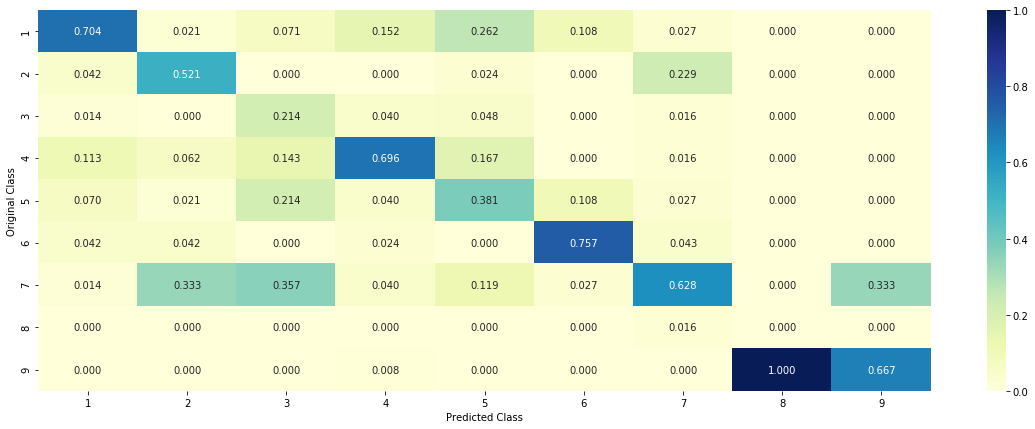

-------------------- Recall matrix (Row sum=1) --------------------


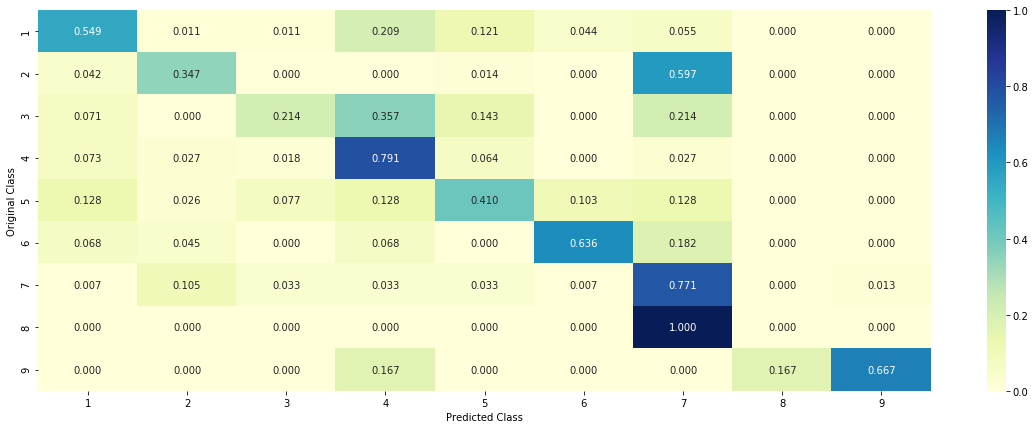

CPU times: user 25.4 s, sys: 11.6 s, total: 37.1 s
Wall time: 15.2 s


In [66]:
%%time
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

#### `FI(for correctly classified points)`

In [67]:
%%time

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.652  0.0317 0.0052 0.1803 0.0067 0.0135 0.1023 0.0041 0.0041]]
Actual Class : 4
--------------------------------------------------
245 Text feature [fanca] present in test data point [True]
265 Text feature [valuable] present in test data point [True]
320 Text feature [brdurd] present in test data point [True]
321 Text feature [mv1lu] present in test data point [True]
349 Text feature [h1299] present in test data point [True]
430 Text feature [slug] present in test data point [True]
439 Text feature [rii] present in test data point [True]
445 Text feature [stains] present in test data point [True]
Out of the top  500  features  8 are present in query point
CPU times: user 27.4 s, sys: 1.71 s, total: 29.1 s
Wall time: 26 s


#### `FI for Incorrectly classified point`

In [68]:
%%time

test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.7904 0.0485 0.0123 0.0805 0.0168 0.0071 0.0372 0.0041 0.0031]]
Actual Class : 1
--------------------------------------------------
115 Text feature [mounting] present in test data point [True]
380 Text feature [nis] present in test data point [True]
422 Text feature [abrogating] present in test data point [True]
Out of the top  500  features  3 are present in query point
CPU times: user 24.7 s, sys: 32 ms, total: 24.7 s
Wall time: 24.7 s


# `RF-TFidf`

In [69]:
alpha = [100,200,300, 400]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 



best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2374781697053527
for n_estimators = 100 and max depth =  10
Log Loss : 1.1929185575671617
for n_estimators = 200 and max depth =  5
Log Loss : 1.226109914331101
for n_estimators = 200 and max depth =  10
Log Loss : 1.185423081291135
for n_estimators = 300 and max depth =  5
Log Loss : 1.2218381504955445
for n_estimators = 300 and max depth =  10
Log Loss : 1.1736182953056706
for n_estimators = 400 and max depth =  5
Log Loss : 1.2217578548970676
for n_estimators = 400 and max depth =  10
Log Loss : 1.1714570668419828
For values of best estimator =  400 The train log loss is: 0.6280056951680426
For values of best estimator =  400 The cross validation log loss is: 1.1714570668419828
For values of best estimator =  400 The test log loss is: 1.1116109057759938


## `Optimal RF-TFidf Model(One Hot Encoding)`

Log loss : 1.1714570668419828
Number of mis-classified points : 0.39097744360902253
-------------------- Confusion matrix --------------------


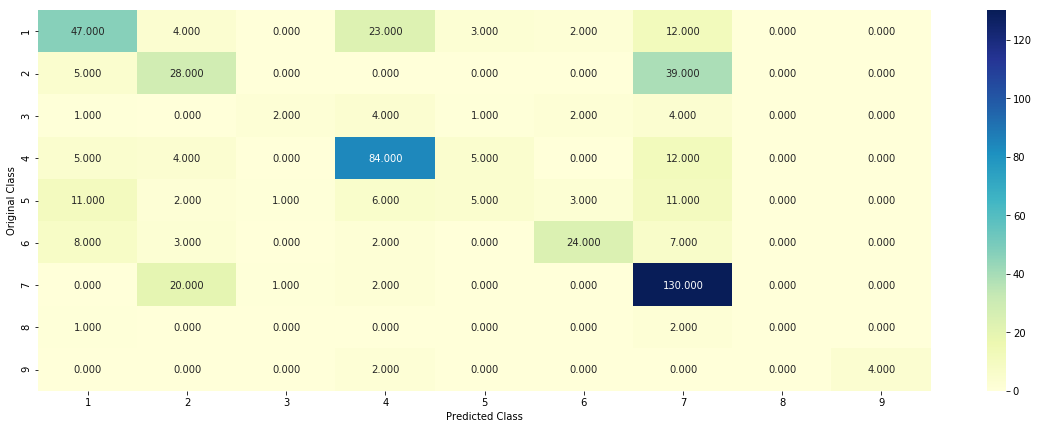

-------------------- Precision matrix (Columm Sum=1) --------------------


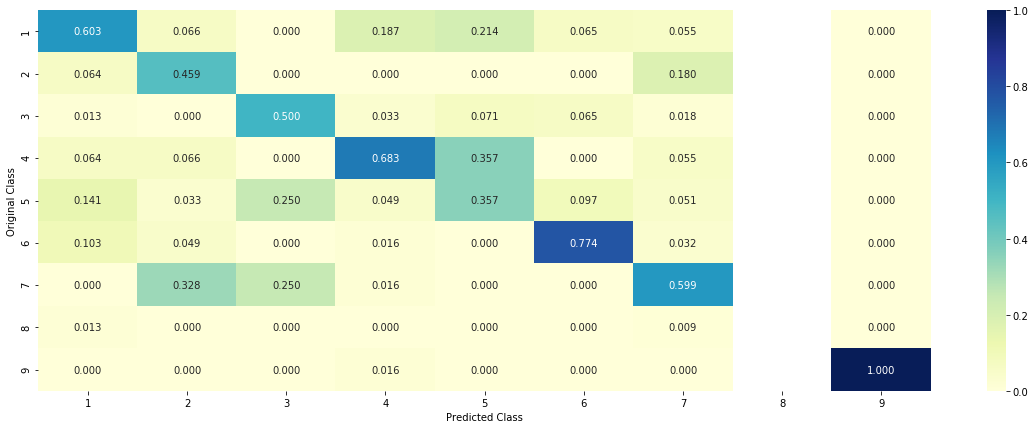

-------------------- Recall matrix (Row sum=1) --------------------


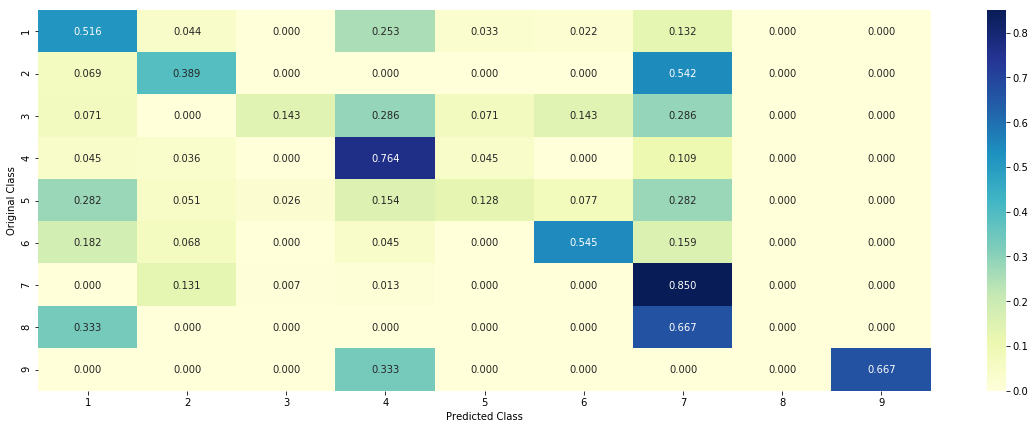

CPU times: user 4min 4s, sys: 2.69 s, total: 4min 7s
Wall time: 1min 6s


In [70]:
%%time

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

#### `Feature Importance(with correctly classified points)`

In [71]:
%%time

# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1758 0.1524 0.0187 0.1027 0.0513 0.0439 0.4374 0.0075 0.0102]]
Actual Class : 4
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [inhibitors] present in test data point [True]
2 Text feature [activation] present in test data point [True]
3 Text feature [suppressor] present in test data point [True]
4 Text feature [activating] present in test data point [True]
5 Text feature [signaling] present in test data point [True]
6 Text feature [oncogenic] present in test data point [True]
8 Text feature [treatment] present in test data point [True]
9 Text feature [inhibitor] present in test data point [True]
10 Text feature [loss] present in test data point [True]
11 Text feature [nonsense] present in test data point [True]
12 Text feature [missense] present in test data point [True]
14 Text feature [activated] present in test data point [True]
15 Text feature [drug] 

#### `Feature importance with incorrectly classified points`

In [72]:
%%time

test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.3957 0.0838 0.0205 0.2529 0.0583 0.0446 0.1177 0.0175 0.0091]]
Actuall Class : 1
--------------------------------------------------
2 Text feature [activation] present in test data point [True]
3 Text feature [suppressor] present in test data point [True]
5 Text feature [signaling] present in test data point [True]
8 Text feature [treatment] present in test data point [True]
10 Text feature [loss] present in test data point [True]
12 Text feature [missense] present in test data point [True]
14 Text feature [activated] present in test data point [True]
19 Text feature [function] present in test data point [True]
20 Text feature [phosphorylation] present in test data point [True]
21 Text feature [downstream] present in test data point [True]
22 Text feature [functional] present in test data point [True]
23 Text feature [receptor] present in test data point [True]
28 Text feature [growth] present in test data point [True]
32 Text feat

## `RF-TFidf(ResponseCoding)`

In [73]:
%%time
alpha = [10,50,100,200,300]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 1.9486371371795312
for n_estimators = 10 and max depth =  3
Log Loss : 1.6625024471236471
for n_estimators = 10 and max depth =  5
Log Loss : 1.5475811133296262
for n_estimators = 10 and max depth =  10
Log Loss : 1.9247035935559647
for n_estimators = 50 and max depth =  2
Log Loss : 1.6224840302864731
for n_estimators = 50 and max depth =  3
Log Loss : 1.399036860112979
for n_estimators = 50 and max depth =  5
Log Loss : 1.301606012653997
for n_estimators = 50 and max depth =  10
Log Loss : 1.7331936448995313
for n_estimators = 100 and max depth =  2
Log Loss : 1.5217016848918838
for n_estimators = 100 and max depth =  3
Log Loss : 1.4026549108054118
for n_estimators = 100 and max depth =  5
Log Loss : 1.2947214303329104
for n_estimators = 100 and max depth =  10
Log Loss : 1.7024840080564134
for n_estimators = 200 and max depth =  2
Log Loss : 1.5882685574247413
for n_estimators = 200 and max depth =  3
Log Loss : 1.4143798106419583

## ` Optimal RF-TFidf(Response Coding) model`

Log loss : 1.2947214303329104
Number of mis-classified points : 0.44548872180451127
-------------------- Confusion matrix --------------------


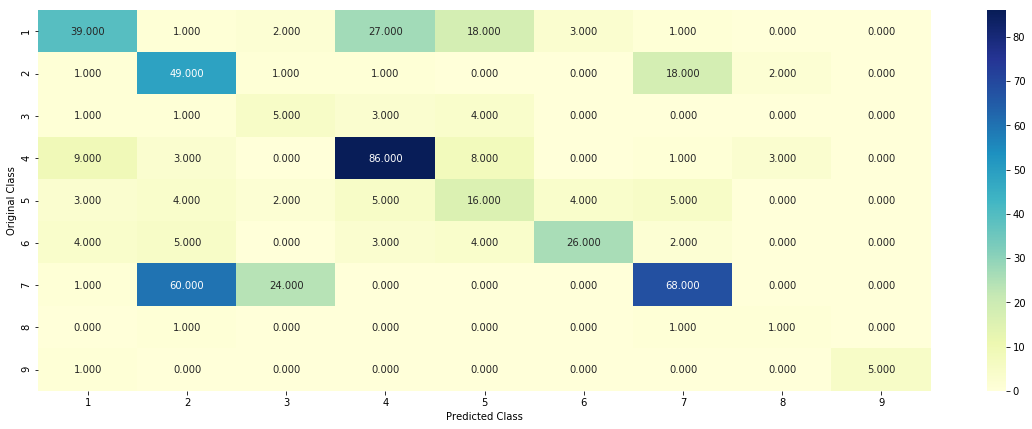

-------------------- Precision matrix (Columm Sum=1) --------------------


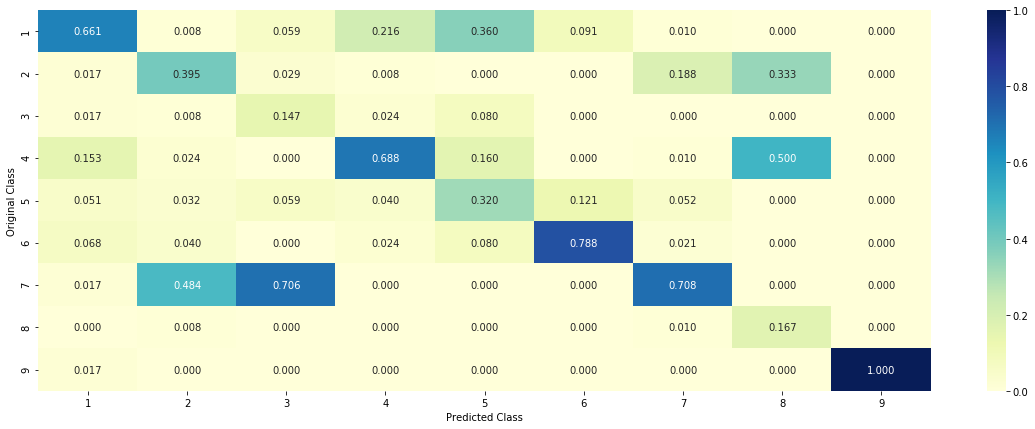

-------------------- Recall matrix (Row sum=1) --------------------


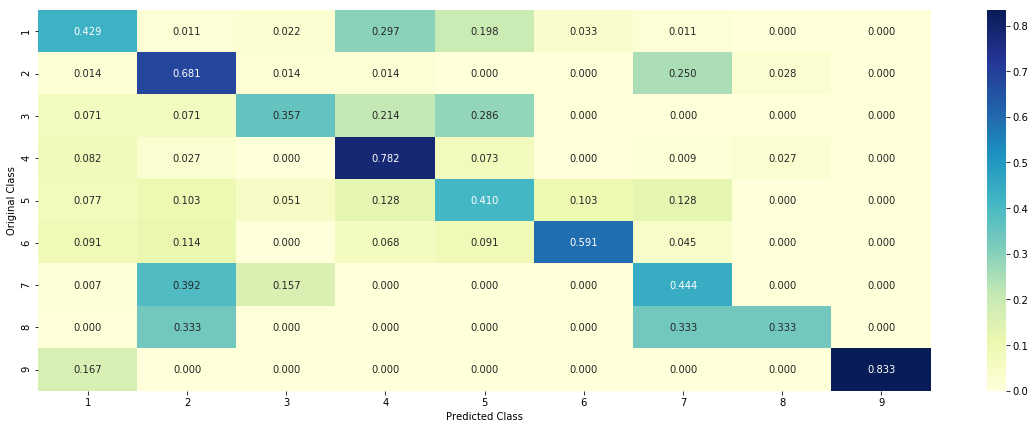

CPU times: user 6.01 s, sys: 1.58 s, total: 7.58 s
Wall time: 4.63 s


In [74]:
%%time

clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

#### `FI(Correctly classified points)`

In [75]:
%%time

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 1
Predicted Class Probabilities: [[0.8012 0.0019 0.0023 0.184  0.0016 0.003  0.0018 0.0019 0.0023]]
Actual Class : 4
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature
CPU times: user 4.12 s, sys: 648 ms, total: 4.77 s
Wall time: 3.87 

#### `FI(icorrectly classified points)`

In [76]:
%%time

test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 1
Predicted Class Probabilities: [[0.3485 0.032  0.0877 0.3282 0.0449 0.0398 0.0128 0.0651 0.041 ]]
Actual Class : 1
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature
CPU times: user 368 ms, sys: 68 ms, total: 436 ms
Wall time: 1.14 s

# `Stacking models with TFidf Vectorizers`

In [77]:
%%time

clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.17
Support vector machines : Log Loss: 1.48
Naive Bayes : Log Loss: 1.34
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.817
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.715
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.331
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.252
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.553
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.927
CPU times: user 4min 25s, sys: 2min 3s, total: 6min 28s
Wall time: 2min 38s


## `Optimal stacking-TFidf Model`

Log loss (train) on the stacking classifier : 0.47409833623526215
Log loss (CV) on the stacking classifier : 1.252427133479127
Log loss (test) on the stacking classifier : 1.1425201236743383
Number of missclassified point : 0.3533834586466165
-------------------- Confusion matrix --------------------


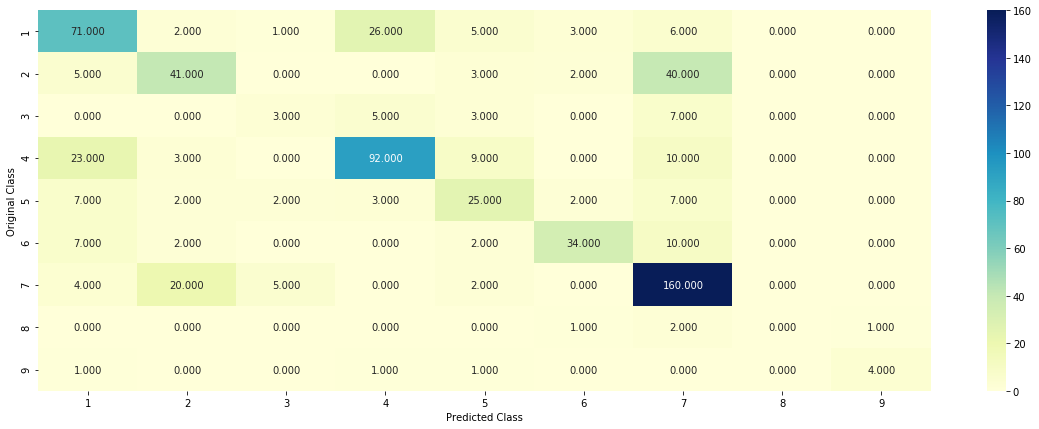

-------------------- Precision matrix (Columm Sum=1) --------------------


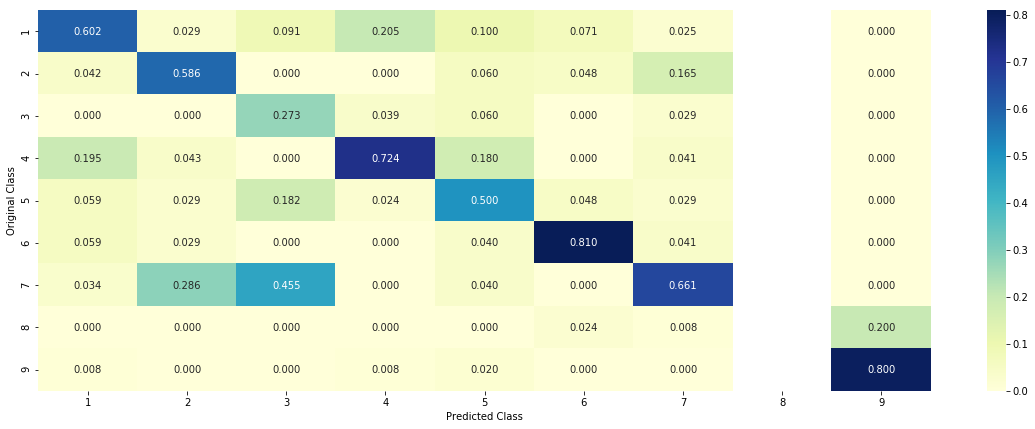

-------------------- Recall matrix (Row sum=1) --------------------


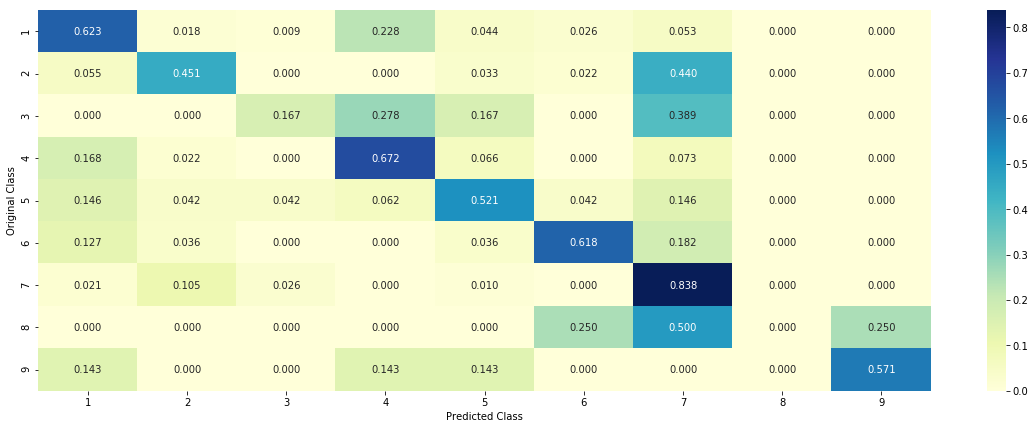

In [78]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

## `Maximum voting TF-idf model`

Log loss (train) on the VotingClassifier : 0.7892347231467284
Log loss (CV) on the VotingClassifier : 1.182859040785359
Log loss (test) on the VotingClassifier : 1.1170313155425964
Number of missclassified point : 0.3533834586466165
-------------------- Confusion matrix --------------------


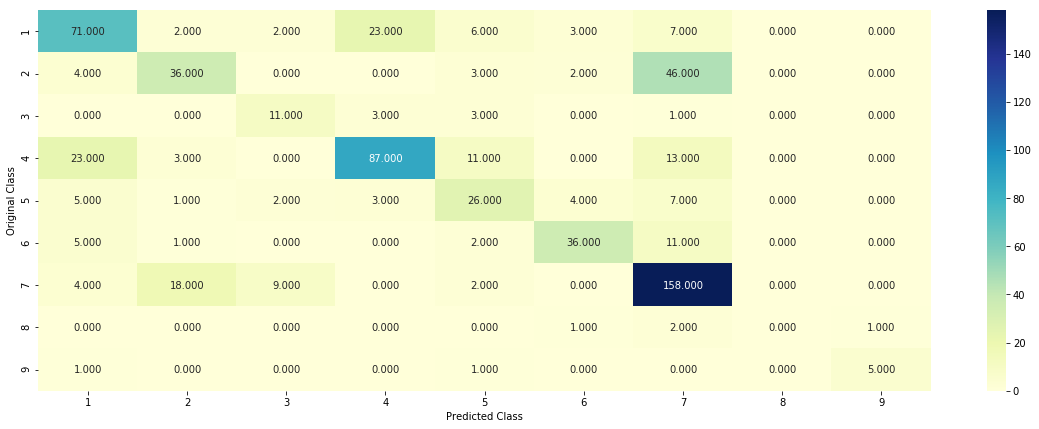

-------------------- Precision matrix (Columm Sum=1) --------------------


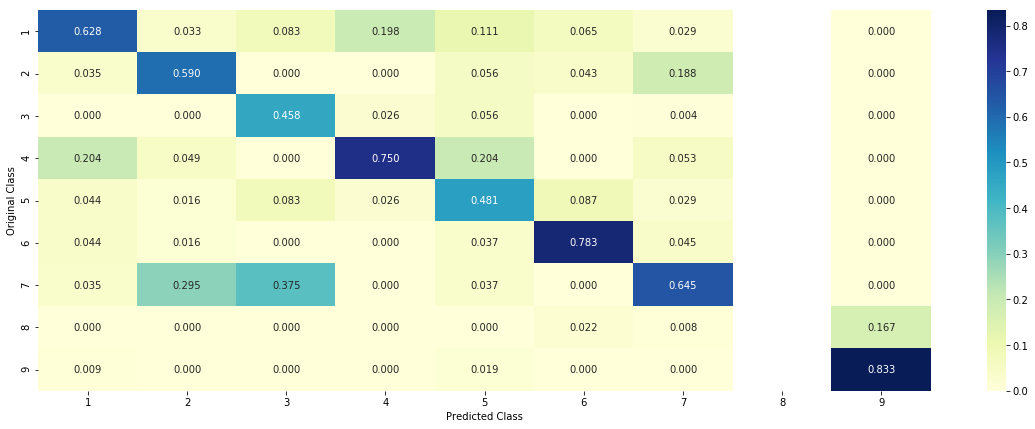

-------------------- Recall matrix (Row sum=1) --------------------


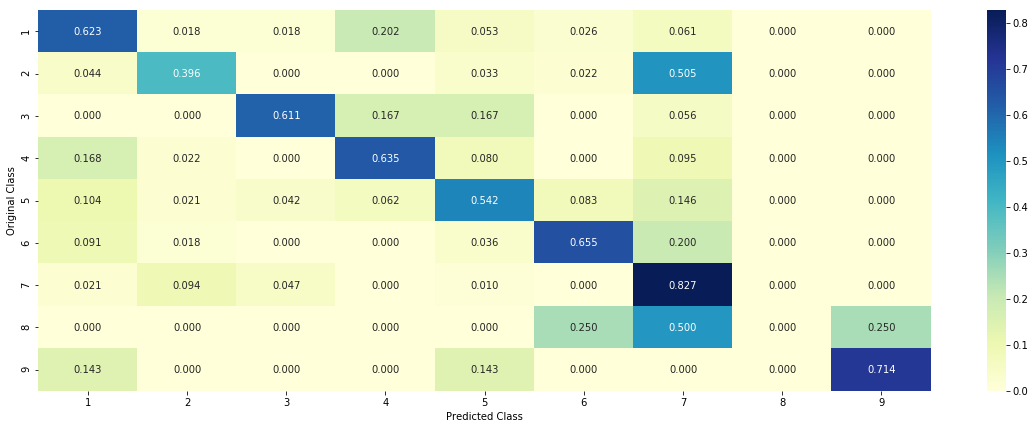

CPU times: user 41.1 s, sys: 18.3 s, total: 59.4 s
Wall time: 25.3 s


In [79]:
%%time

#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))

# `PROJECT 002 - Models withTFidf(Top 1000Features)`

### `Train Test split`

In [9]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

## ` "TEXT" feature response coding functions`

In [12]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [13]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

## `Common functions`

In [14]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [15]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [16]:
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

## ` features to vector conversion and stacking`

In [18]:
# one-hot encoding of Gene feature.
gene_vectorizer = TfidfVectorizer(max_features=1000)
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [19]:
# one-hot encoding of variation feature.
variation_vectorizer = TfidfVectorizer(max_features=1000)
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [20]:
# building a TFidfVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(min_df=3, max_features=1000)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 1000


In [21]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [22]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [23]:
%%time

train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.13 ms


In [24]:
%%time

train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

CPU times: user 5.78 s, sys: 16 ms, total: 5.8 s
Wall time: 5.79 s


In [26]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [27]:
%%time

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


CPU times: user 88 ms, sys: 16 ms, total: 104 ms
Wall time: 101 ms


# ` NB-TFidf with top 1000 features`

for alpha = 1e-05
Log Loss : 1.1861968156892388
for alpha = 0.0001
Log Loss : 1.1861916824803314
for alpha = 0.001
Log Loss : 1.1854986320716119
for alpha = 0.1
Log Loss : 1.183051628242224
for alpha = 1
Log Loss : 1.2074890760054782
for alpha = 10
Log Loss : 1.3720445421209428
for alpha = 100
Log Loss : 1.411771374328022
for alpha = 1000
Log Loss : 1.4135335416140797


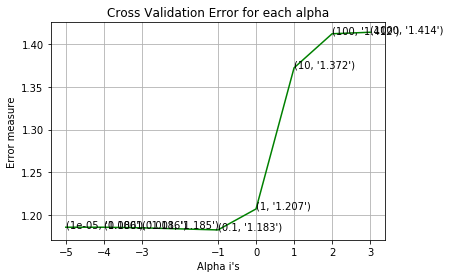

For values of best alpha =  0.1 The train log loss is: 0.755428577340699
For values of best alpha =  0.1 The cross validation log loss is: 1.183051628242224
For values of best alpha =  0.1 The test log loss is: 1.212875614948166
CPU times: user 2.75 s, sys: 280 ms, total: 3.03 s
Wall time: 2.62 s


In [28]:
%%time

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


## `optimal NB-TFidf model`

Log Loss : 1.183051628242224
Number of missclassified point : 0.3815789473684211
-------------------- Confusion matrix --------------------


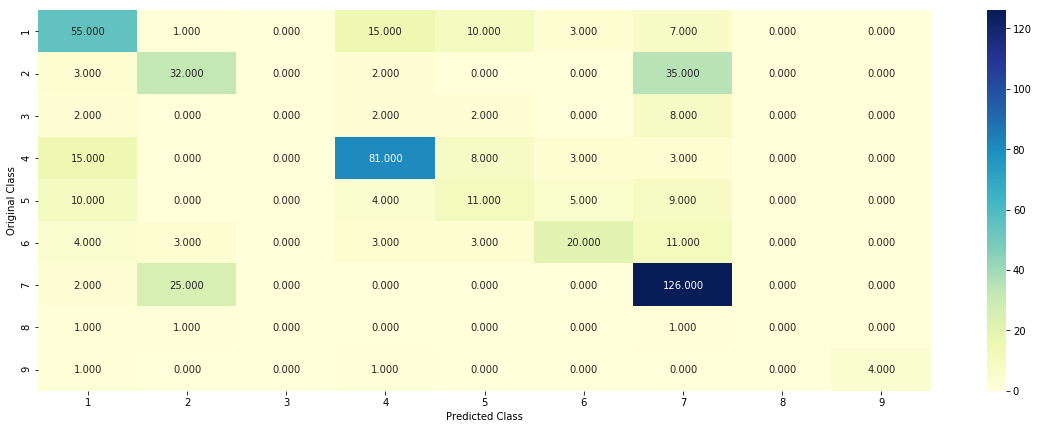

-------------------- Precision matrix (Columm Sum=1) --------------------


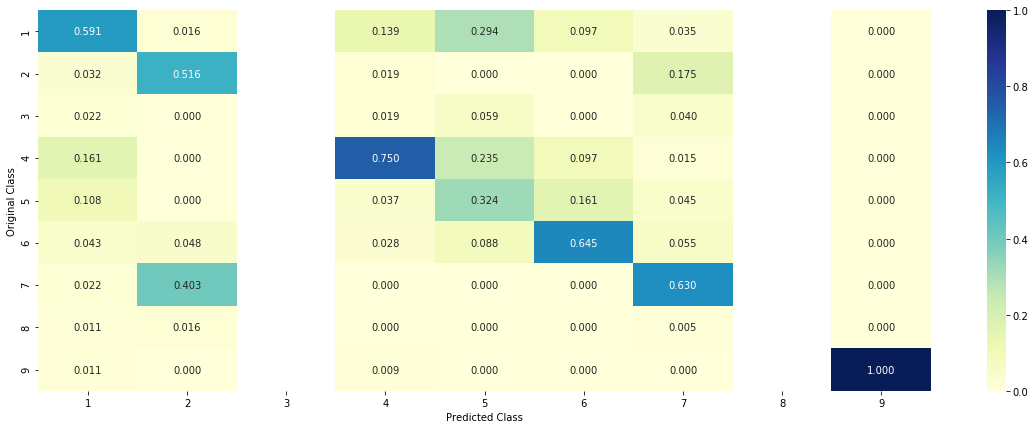

-------------------- Recall matrix (Row sum=1) --------------------


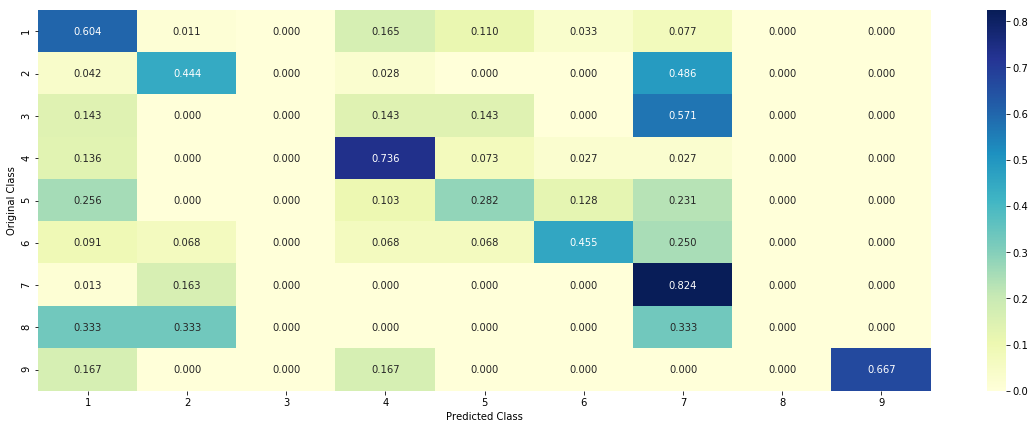

CPU times: user 4.11 s, sys: 1.84 s, total: 5.96 s
Wall time: 2.61 s


In [29]:
%%time

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

#### `FI with correctly classified points`

In [30]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[0.0466 0.0405 0.0149 0.0488 0.0327 0.764  0.0432 0.0046 0.0048]]
Actual Class : 6
--------------------------------------------------
Out of the top  100  features  0 are present in query point


#### `FI with incorrectly classified points`

In [31]:
%%time

test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0511 0.0685 0.0162 0.0549 0.037  0.0329 0.7294 0.0049 0.0052]]
Actual Class : 1
--------------------------------------------------
Out of the top  100  features  0 are present in query point
CPU times: user 10 s, sys: 68 ms, total: 10.1 s
Wall time: 10.1 s


## `KNN-TFidf with 1000 top features`

for alpha = 5
Log Loss : 1.0771193883699404
for alpha = 11
Log Loss : 1.0640535636133766
for alpha = 15
Log Loss : 1.0859316441454119
for alpha = 21
Log Loss : 1.0913965497835332
for alpha = 31
Log Loss : 1.0889000696772668
for alpha = 41
Log Loss : 1.0940618299294464
for alpha = 51
Log Loss : 1.1056857177756256
for alpha = 99
Log Loss : 1.118090470065787


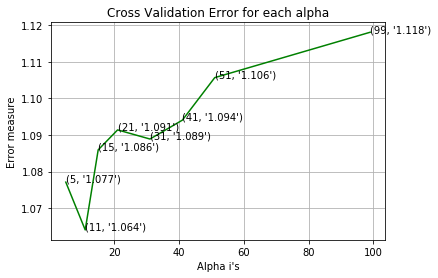

For values of best alpha =  11 The train log loss is: 0.6118490972619433
For values of best alpha =  11 The cross validation log loss is: 1.0640535636133766
For values of best alpha =  11 The test log loss is: 1.0474755273594127
CPU times: user 3.88 s, sys: 280 ms, total: 4.16 s
Wall time: 3.73 s


In [32]:
%%time

alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


## `Optimal KNN-TFidf model`

Log loss : 1.0640535636133766
Number of mis-classified points : 0.35526315789473684
-------------------- Confusion matrix --------------------


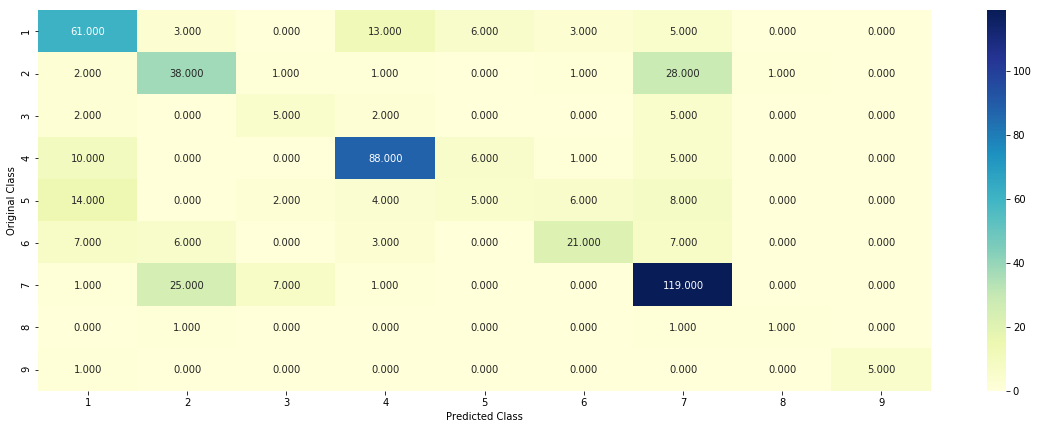

-------------------- Precision matrix (Columm Sum=1) --------------------


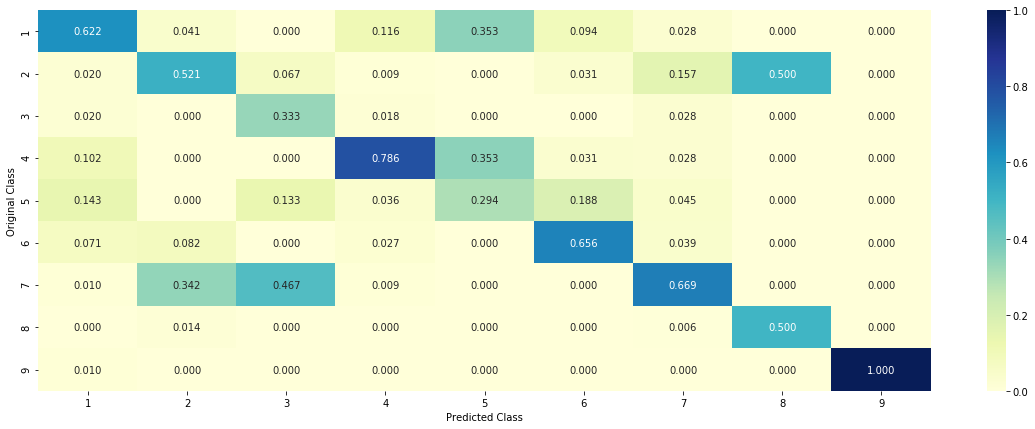

-------------------- Recall matrix (Row sum=1) --------------------


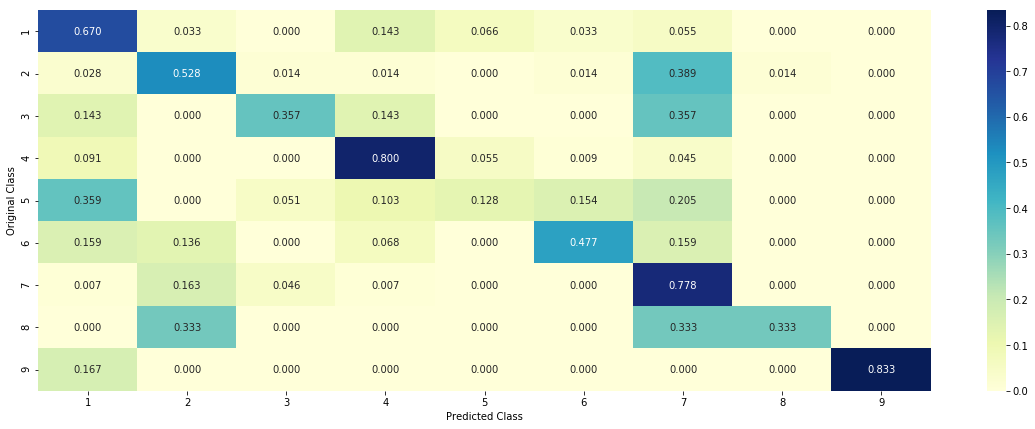

CPU times: user 3.98 s, sys: 1.55 s, total: 5.53 s
Wall time: 2.6 s


In [33]:
%%time

clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

#### `Sample Query point 1`

In [34]:
%%time

clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 6
The  11  nearest neighbours of the test points belongs to classes [6 6 6 6 6 6 6 6 6 6 6]
Fequency of nearest points : Counter({6: 11})
CPU times: user 216 ms, sys: 4 ms, total: 220 ms
Wall time: 215 ms


#### `Sample Query Point 2`

In [35]:
%%time

clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 1
the k value for knn is 11 and the nearest neighbours of the test points belongs to classes [5 7 7 7 5 7 7 7 7 7 7]
Fequency of nearest points : Counter({7: 9, 5: 2})
CPU times: user 212 ms, sys: 0 ns, total: 212 ms
Wall time: 207 ms


# ` SVM-TFidf(Top 1000 features)`

for C = 1e-05
Log Loss : 1.1733320704520902
for C = 0.0001
Log Loss : 1.154306012656147
for C = 0.001
Log Loss : 1.151363167645414
for C = 0.01
Log Loss : 1.3606409236649464
for C = 0.1
Log Loss : 1.5831610900370894
for C = 1
Log Loss : 1.7393285616803227
for C = 10
Log Loss : 1.7393281295552594
for C = 100
Log Loss : 1.7393284075598272


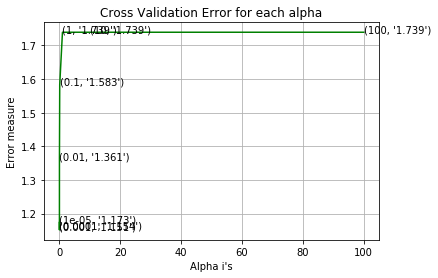

For values of best alpha =  0.001 The train log loss is: 0.7909909031844472
For values of best alpha =  0.001 The cross validation log loss is: 1.151363167645414
For values of best alpha =  0.001 The test log loss is: 1.1453943353605593
CPU times: user 18.9 s, sys: 256 ms, total: 19.1 s
Wall time: 18.6 s


In [36]:
%%time
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

## `Optimal SVM-TFidf model`

Log loss : 1.151363167645414
Number of mis-classified points : 0.35150375939849626
-------------------- Confusion matrix --------------------


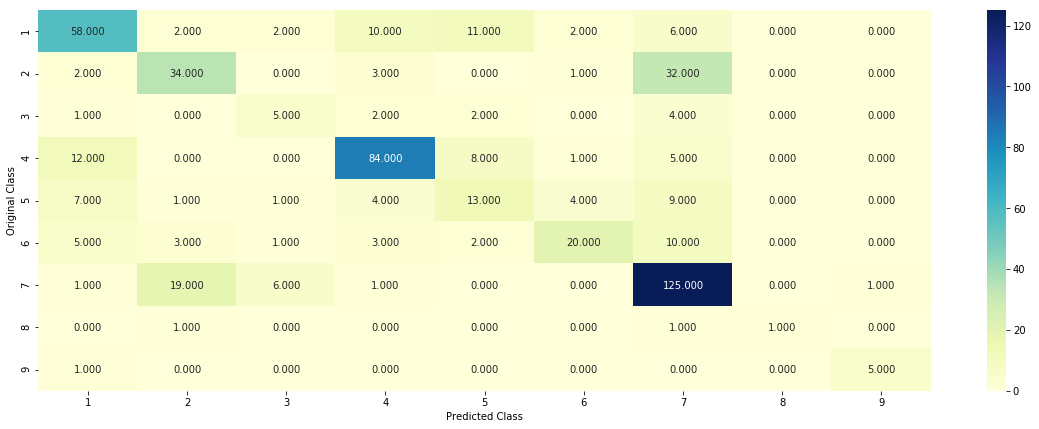

-------------------- Precision matrix (Columm Sum=1) --------------------


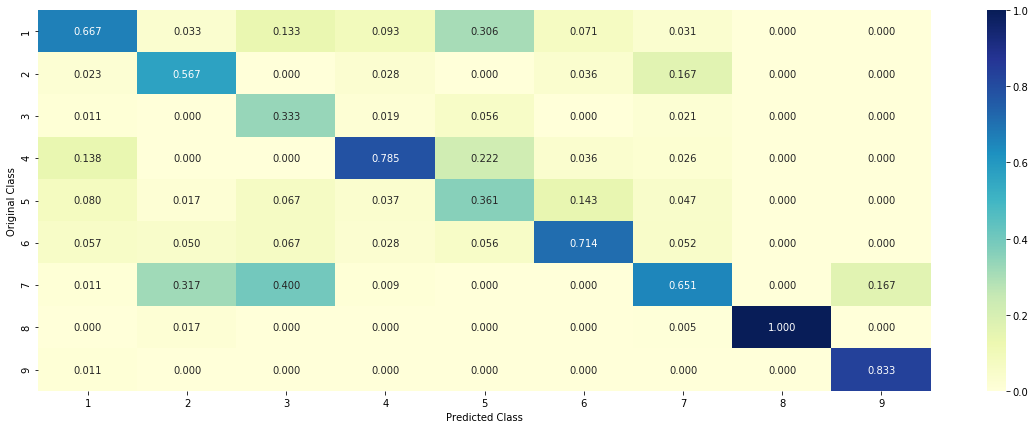

-------------------- Recall matrix (Row sum=1) --------------------


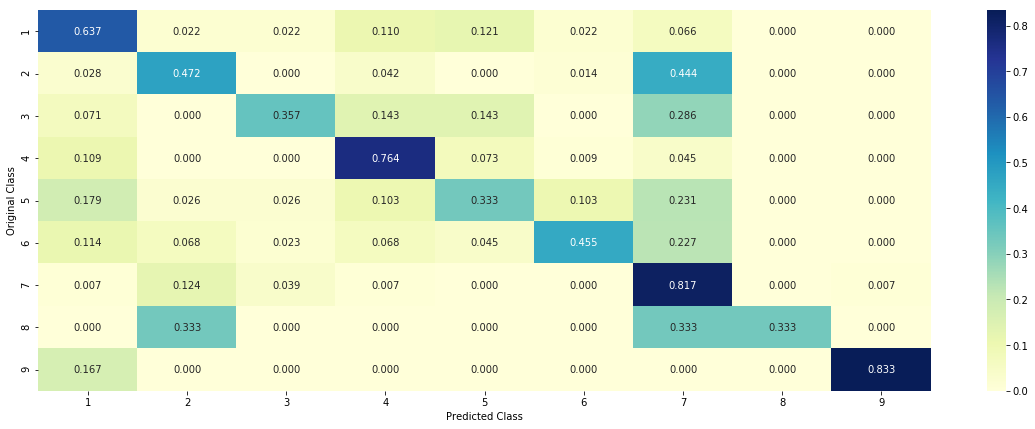

CPU times: user 5.73 s, sys: 1.73 s, total: 7.46 s
Wall time: 4.54 s


In [37]:
%%time
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

#### `FI(correctly classified points)`

In [38]:
%%time

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[0.055  0.0599 0.002  0.0601 0.0283 0.7221 0.0703 0.0012 0.0011]]
Actual Class : 6
--------------------------------------------------
Out of the top  500  features  0 are present in query point
CPU times: user 11.6 s, sys: 76 ms, total: 11.7 s
Wall time: 11.7 s


#### ` FI for incorrectly classified points`

In [39]:
%%time

test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 5
Predicted Class Probabilities: [[0.027  0.0247 0.0042 0.0875 0.4351 0.0017 0.4153 0.0021 0.0025]]
Actual Class : 1
--------------------------------------------------
Out of the top  500  features  0 are present in query point
CPU times: user 10.8 s, sys: 56 ms, total: 10.9 s
Wall time: 10.9 s


## `RF-TFidf(Top 1000 Features)`

In [40]:
%%time

alpha = [100,200,300, 400, 500]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.1769631877997004
for n_estimators = 100 and max depth =  10
Log Loss : 1.2045114579089171
for n_estimators = 200 and max depth =  5
Log Loss : 1.176872015583644
for n_estimators = 200 and max depth =  10
Log Loss : 1.2008109786475607
for n_estimators = 300 and max depth =  5
Log Loss : 1.174486378689211
for n_estimators = 300 and max depth =  10
Log Loss : 1.199962348585846
for n_estimators = 400 and max depth =  5
Log Loss : 1.171187795919884
for n_estimators = 400 and max depth =  10
Log Loss : 1.2030704763875433
for n_estimators = 500 and max depth =  5
Log Loss : 1.169848422611525
for n_estimators = 500 and max depth =  10
Log Loss : 1.2009157300045734
For values of best estimator =  500 The train log loss is: 0.8537127771015307
For values of best estimator =  500 The cross validation log loss is: 1.169848422611525
For values of best estimator =  500 The test log loss is: 1.193203593955846
CPU times: user 12min 22s, sys: 15 s, 

## `Optimal RF-TFidf Model`

Log loss : 1.169848422611525
Number of mis-classified points : 0.40789473684210525
-------------------- Confusion matrix --------------------


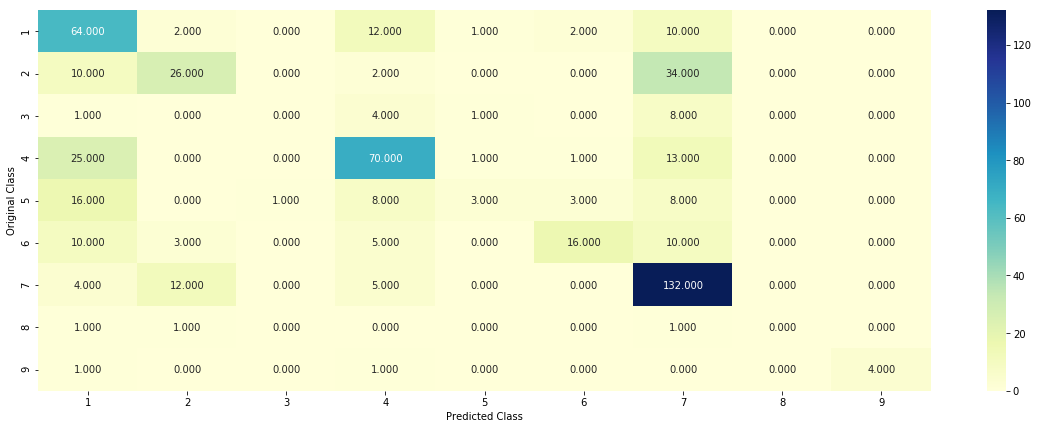

-------------------- Precision matrix (Columm Sum=1) --------------------


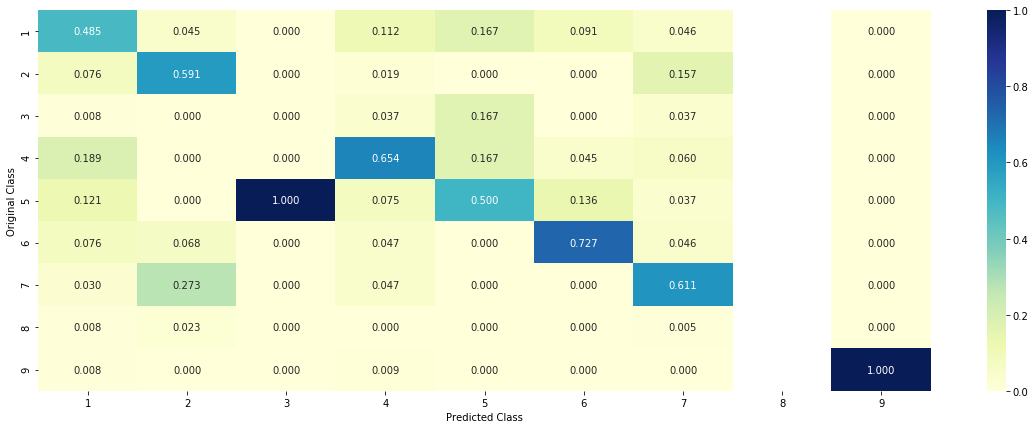

-------------------- Recall matrix (Row sum=1) --------------------


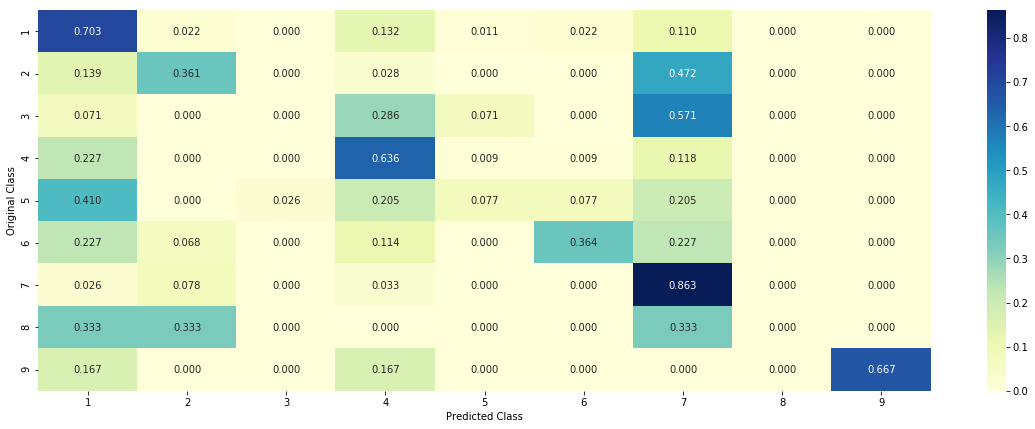

In [41]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

#### `FI(Correctly classified points)`

In [42]:
%%time

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[0.0246 0.0031 0.0036 0.0134 0.1395 0.8041 0.0089 0.0009 0.0019]]
Actual Class : 6
--------------------------------------------------
Out of the top  100  features  0 are present in query point
CPU times: user 1min 5s, sys: 2.09 s, total: 1min 8s
Wall time: 30.1 s


#### `FI(Incorrectly classified points`)

In [43]:
%%time

test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0317 0.2397 0.0274 0.0335 0.058  0.0374 0.5556 0.0099 0.0068]]
Actuall Class : 1
--------------------------------------------------
Out of the top  100  features  0 are present in query point
CPU times: user 11.5 s, sys: 364 ms, total: 11.9 s
Wall time: 12.2 s


## `RF-TFidf-ResponseCoding`

In [44]:
%%time

alpha = [10,50,100,200,500]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 1.961172580469298
for n_estimators = 10 and max depth =  3
Log Loss : 1.573276621842353
for n_estimators = 10 and max depth =  5
Log Loss : 1.3469941322726149
for n_estimators = 10 and max depth =  10
Log Loss : 1.8340235888133152
for n_estimators = 50 and max depth =  2
Log Loss : 1.6342325158831046
for n_estimators = 50 and max depth =  3
Log Loss : 1.4237396351826894
for n_estimators = 50 and max depth =  5
Log Loss : 1.3873196218276782
for n_estimators = 50 and max depth =  10
Log Loss : 1.753942005586405
for n_estimators = 100 and max depth =  2
Log Loss : 1.4938008180161837
for n_estimators = 100 and max depth =  3
Log Loss : 1.4340419302999947
for n_estimators = 100 and max depth =  5
Log Loss : 1.3117379385332752
for n_estimators = 100 and max depth =  10
Log Loss : 1.719937335107885
for n_estimators = 200 and max depth =  2
Log Loss : 1.5125606015840873
for n_estimators = 200 and max depth =  3
Log Loss : 1.4379277413350375
f

## `Optimal RF-TFidf (Response Coding) model`

Log loss : 1.3117379385332752
Number of mis-classified points : 0.43796992481203006
-------------------- Confusion matrix --------------------


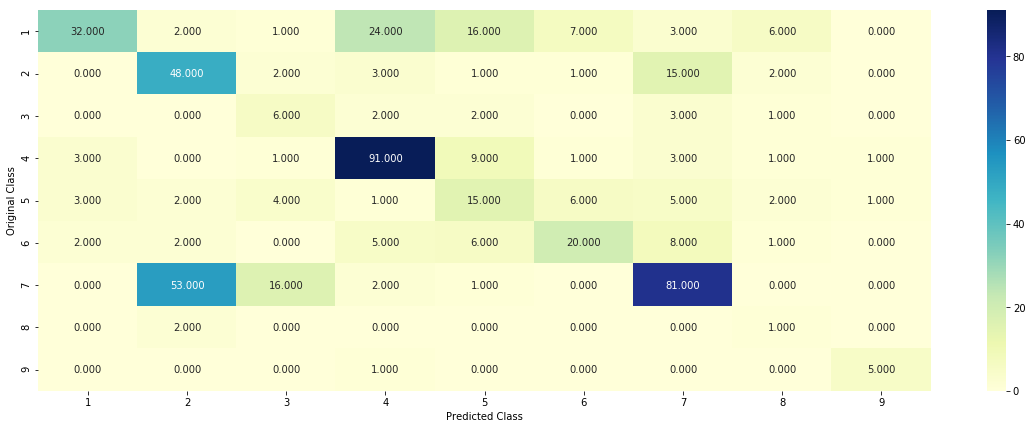

-------------------- Precision matrix (Columm Sum=1) --------------------


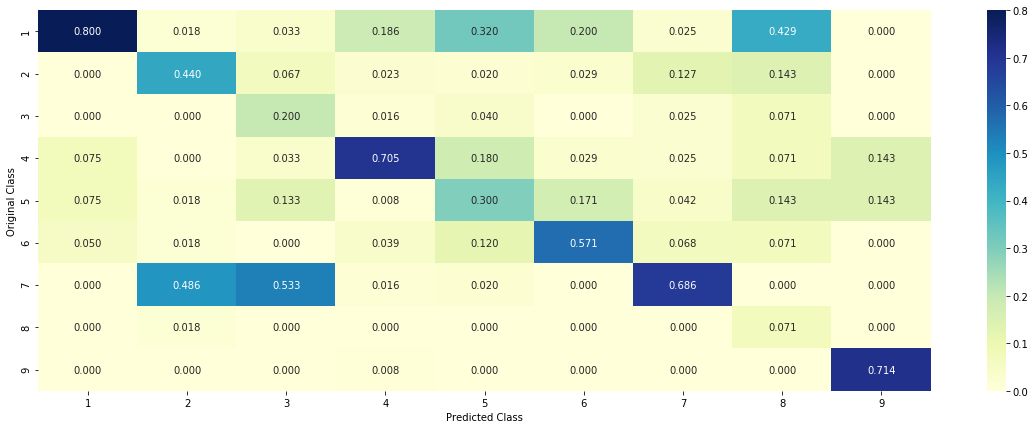

-------------------- Recall matrix (Row sum=1) --------------------


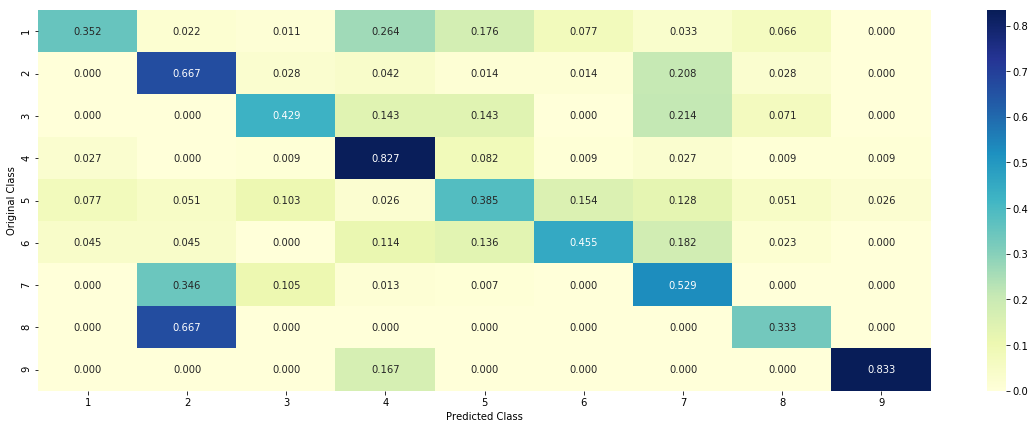

CPU times: user 5.76 s, sys: 1.67 s, total: 7.44 s
Wall time: 4.43 s


In [45]:
%%time

clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

#### `FI(Correctly classified points`)

In [46]:
%%time

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 6
Predicted Class Probabilities: [[0.011  0.0038 0.0206 0.0113 0.1474 0.7895 0.0026 0.007  0.0068]]
Actual Class : 6
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature
CPU times: user 4.06 s, sys: 596 ms, total: 4.66 s
Wall time: 3.86 

#### `FI(incorrectly classified points`)

In [47]:
%%time

test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 8
Predicted Class Probabilities: [[0.0317 0.0678 0.1849 0.0363 0.0963 0.0479 0.0679 0.3525 0.1147]]
Actual Class : 1
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature
CPU times: user 384 ms, sys: 36 ms, total: 420 ms
Wall time: 1.14 s

## `Stacking models-TFidf(with 1000Top features)`

In [48]:
%%time

clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.05
Support vector machines : Log Loss: 1.74
Naive Bayes : Log Loss: 1.19
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.817
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.715
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.313
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.147
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.233
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.334
CPU times: user 35.1 s, sys: 3.32 s, total: 38.4 s
Wall time: 32.8 s


## `Optimal Stacked-TFidf Model`

Log loss (train) on the stacking classifier : 0.6880106210900898
Log loss (CV) on the stacking classifier : 1.1467791404735412
Log loss (test) on the stacking classifier : 1.1666735607853018
Number of missclassified point : 0.3894736842105263
-------------------- Confusion matrix --------------------


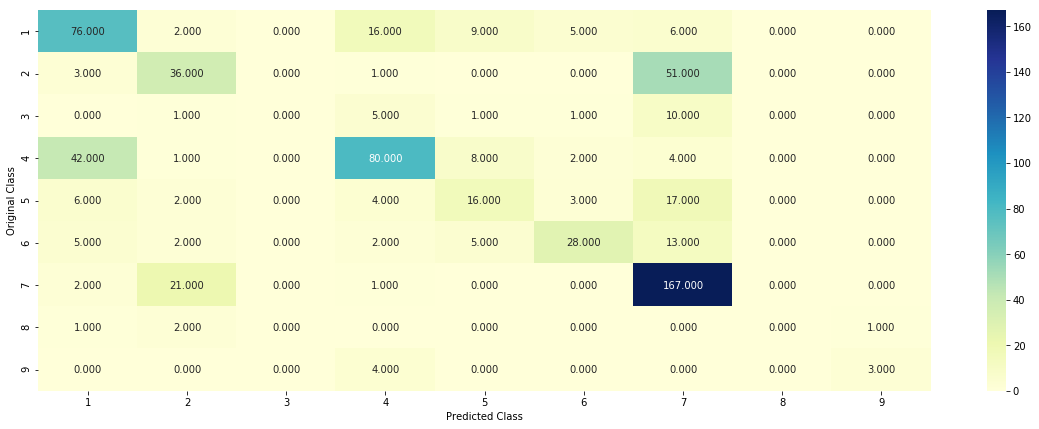

-------------------- Precision matrix (Columm Sum=1) --------------------


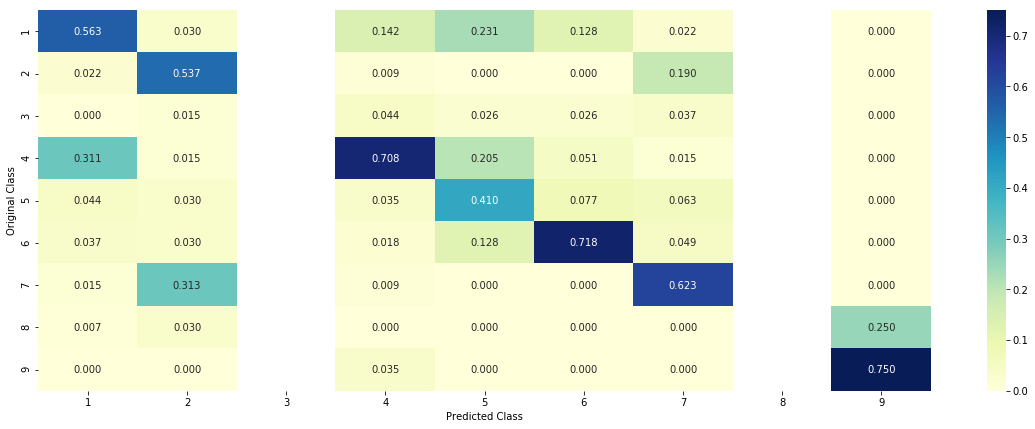

-------------------- Recall matrix (Row sum=1) --------------------


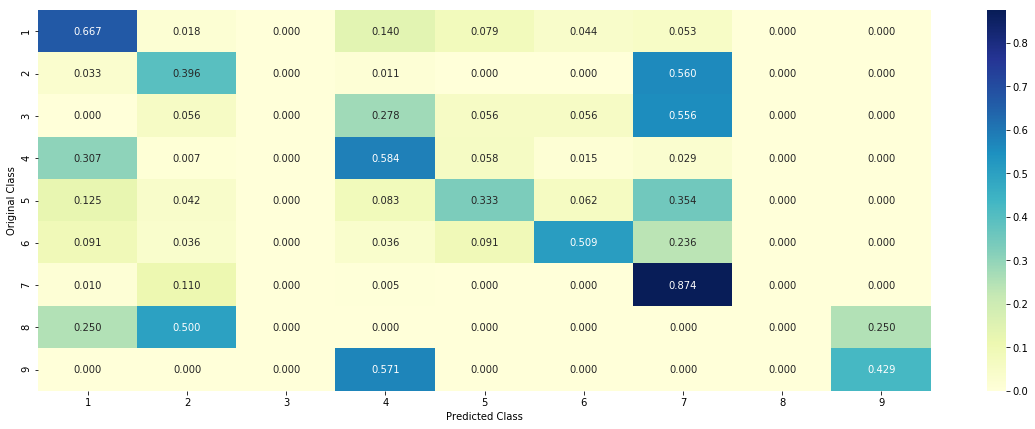

CPU times: user 9.15 s, sys: 2.23 s, total: 11.4 s
Wall time: 7.37 s


In [49]:
%%time

lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

## `MaximumVoting-TFidf(Top 1000 Features)`

Log loss (train) on the VotingClassifier : 0.9186684333040728
Log loss (CV) on the VotingClassifier : 1.178426993187383
Log loss (test) on the VotingClassifier : 1.1925734383270294
Number of missclassified point : 0.3774436090225564
-------------------- Confusion matrix --------------------


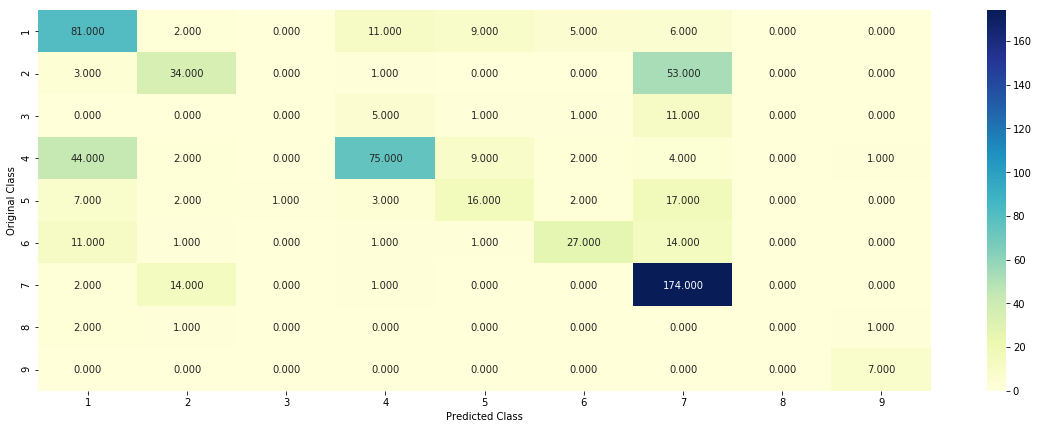

-------------------- Precision matrix (Columm Sum=1) --------------------


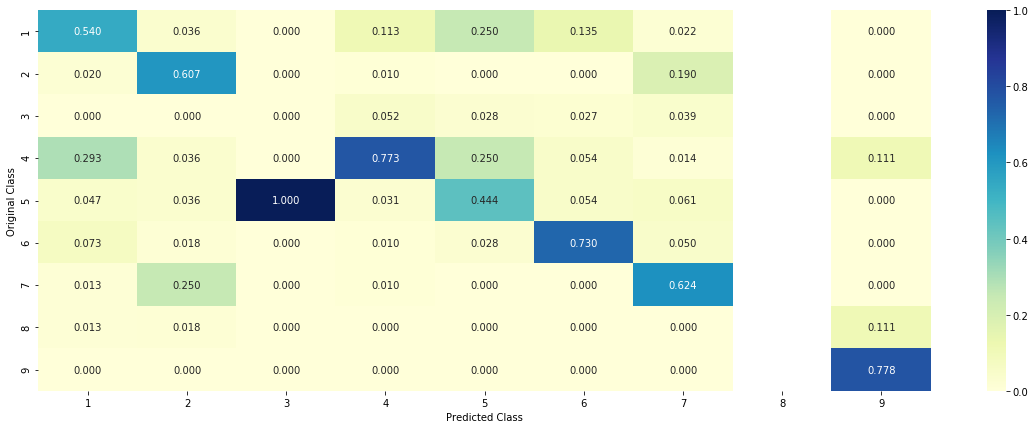

-------------------- Recall matrix (Row sum=1) --------------------


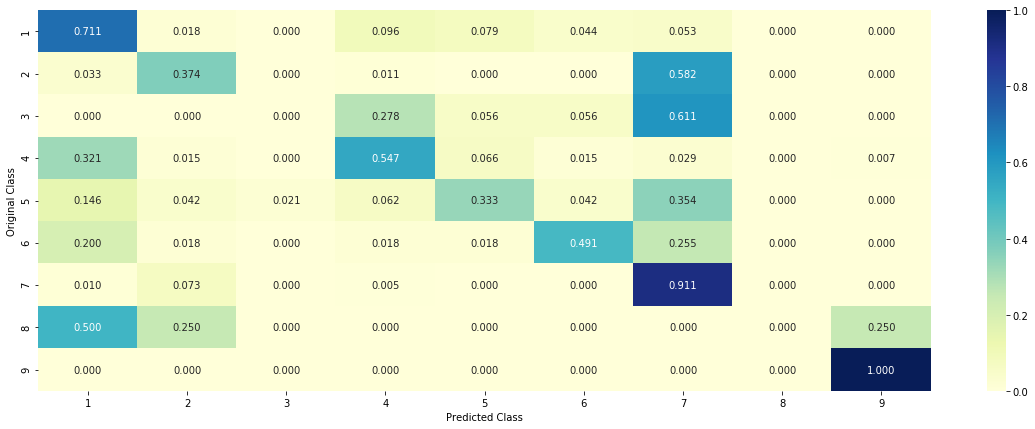

CPU times: user 8.04 s, sys: 1.72 s, total: 9.76 s
Wall time: 6.88 s


In [50]:
%%time
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))

# `Project 003A - LogisticRegression-BoW(UNIGRAM)`

In [52]:
%%time

# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer(ngram_range=(1,1))

train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

train_gene_feature_onehotCoding.shape, test_gene_feature_onehotCoding.shape, cv_gene_feature_onehotCoding.shape

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 16 ms


((2124, 229), (665, 229), (532, 229))

In [53]:
%%time

# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer(ngram_range=(1,1))

train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

train_variation_feature_onehotCoding.shape, test_variation_feature_onehotCoding.shape, cv_variation_feature_onehotCoding.shape

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 21.2 ms


((2124, 1977), (665, 1977), (532, 1977))

## `Strings to vectors conversion  and normalization`

In [54]:
%%time

# building a BoWVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(ngram_range=(1,1))
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))
train_text_feature_onehotCoding.shape

Total number of unique words in train data : 124723
CPU times: user 10.1 s, sys: 76 ms, total: 10.2 s
Wall time: 10.2 s


(2124, 124723)

In [55]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)


In [56]:
%%time

train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

train_text_feature_responseCoding.shape, test_text_feature_responseCoding.shape, cv_text_feature_responseCoding.shape

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.58 ms


((2124, 9), (665, 9), (532, 9))

In [57]:
%%time

train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

CPU times: user 6.74 s, sys: 28 ms, total: 6.77 s
Wall time: 6.77 s


In [58]:
%%time

alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

CPU times: user 2min 15s, sys: 808 ms, total: 2min 16s
Wall time: 2min 14s


## `Stacking`

In [59]:
%%time

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

CPU times: user 248 ms, sys: 40 ms, total: 288 ms
Wall time: 286 ms


# `LR-BoW(n_gram=(1,1)`

for alpha = 1e-06
Log Loss : 1.411748759873326
for alpha = 1e-05
Log Loss : 1.3867793547634795
for alpha = 0.0001
Log Loss : 1.2290368858583018
for alpha = 0.001
Log Loss : 1.1957045020940216
for alpha = 0.01
Log Loss : 1.2622942432775892
for alpha = 0.1
Log Loss : 1.4682156991049633
for alpha = 1
Log Loss : 1.6874437758156386
for alpha = 10
Log Loss : 1.711040166027748
for alpha = 100
Log Loss : 1.7134398800666173


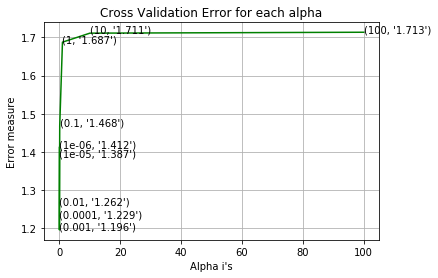

For values of best alpha =  0.001 The train log loss is: 0.48530598607848796
For values of best alpha =  0.001 The cross validation log loss is: 1.1957045020940216
For values of best alpha =  0.001 The test log loss is: 1.179924573359995
CPU times: user 3min 25s, sys: 1min 43s, total: 5min 9s
Wall time: 2min 1s


In [60]:
%%time

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

## `Optimal LR-BoW(Unigram) Model`

Log loss : 1.1957045020940216
Number of mis-classified points : 0.35150375939849626
-------------------- Confusion matrix --------------------


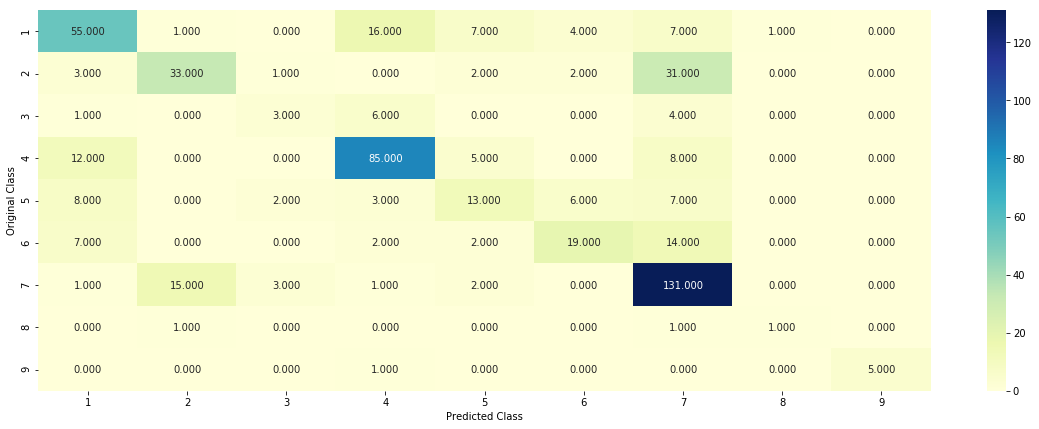

-------------------- Precision matrix (Columm Sum=1) --------------------


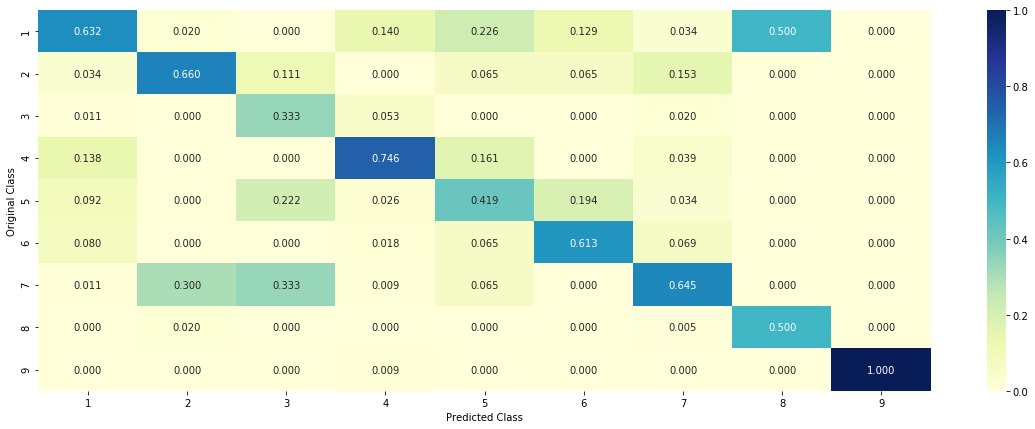

-------------------- Recall matrix (Row sum=1) --------------------


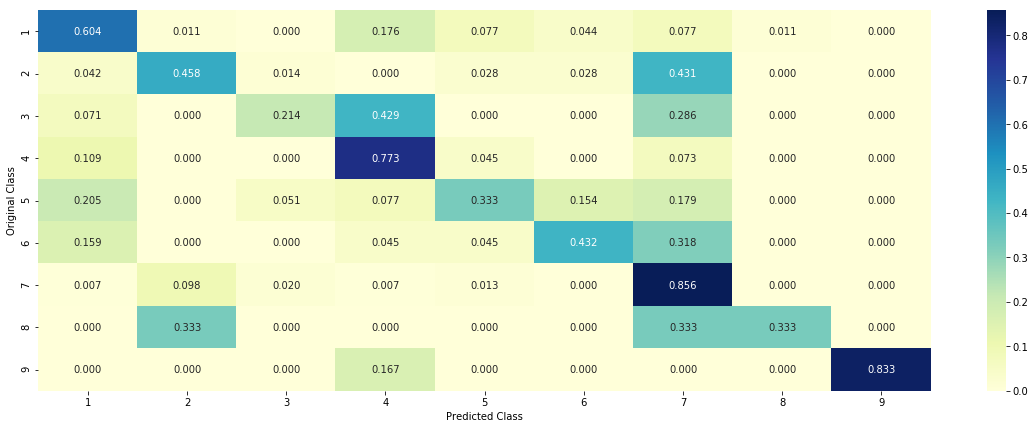

CPU times: user 25.7 s, sys: 11.8 s, total: 37.6 s
Wall time: 15.9 s


In [61]:
%%time

clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

## ` LR-BoW(n_gram(1,1)- without class balancing`

for alpha = 1e-06
Log Loss : 1.3760881791987571
for alpha = 1e-05
Log Loss : 1.3532842946741797
for alpha = 0.0001
Log Loss : 1.206579909990299
for alpha = 0.001
Log Loss : 1.1966061564234525
for alpha = 0.01
Log Loss : 1.289439287780928
for alpha = 0.1
Log Loss : 1.3791603108383519
for alpha = 1
Log Loss : 1.547251333505688


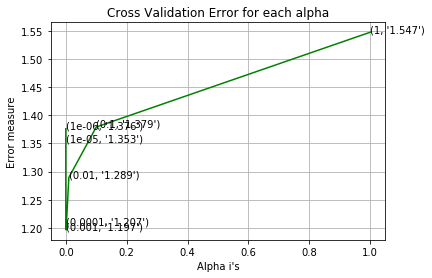

For values of best alpha =  0.001 The train log loss is: 0.4871719939489779
For values of best alpha =  0.001 The cross validation log loss is: 1.1966061564234525
For values of best alpha =  0.001 The test log loss is: 1.1990891798799748
CPU times: user 2min 56s, sys: 1min 21s, total: 4min 18s
Wall time: 1min 48s


In [63]:
%%time

alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

## `Optimal LR-BoW(Unigram) Model`

Log loss : 1.1966061564234525
Number of mis-classified points : 0.3458646616541353
-------------------- Confusion matrix --------------------


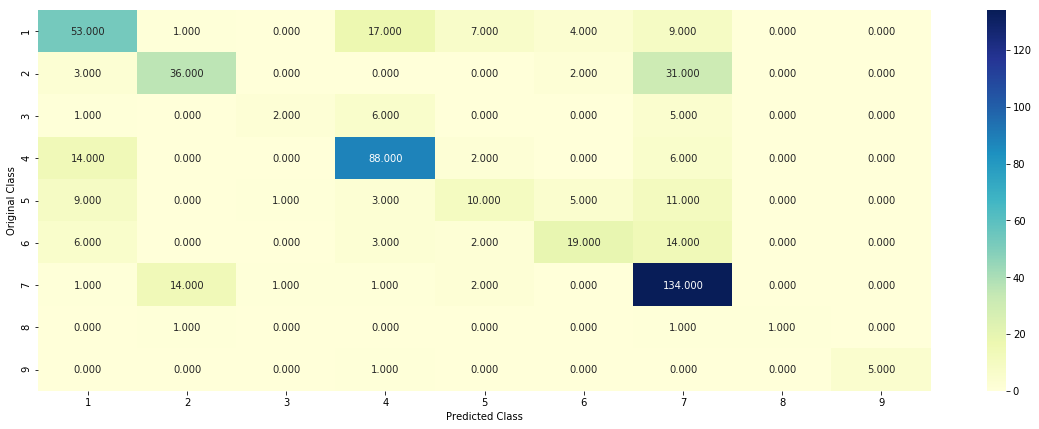

-------------------- Precision matrix (Columm Sum=1) --------------------


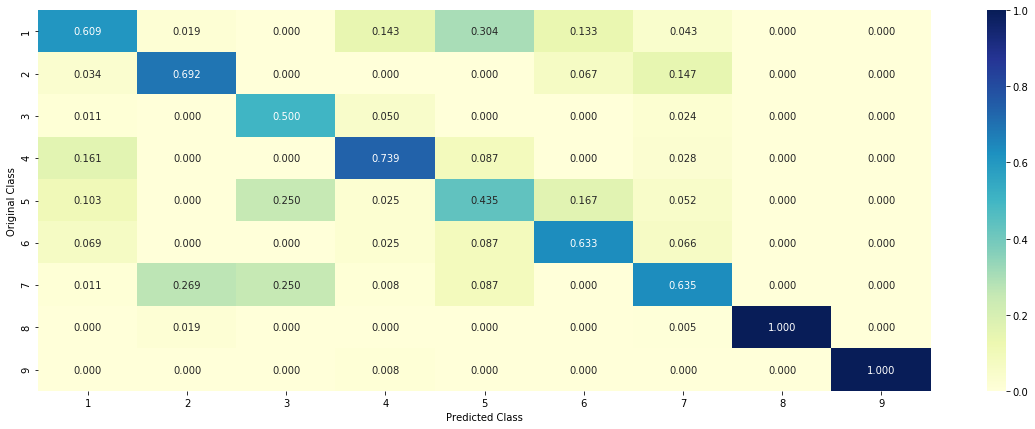

-------------------- Recall matrix (Row sum=1) --------------------


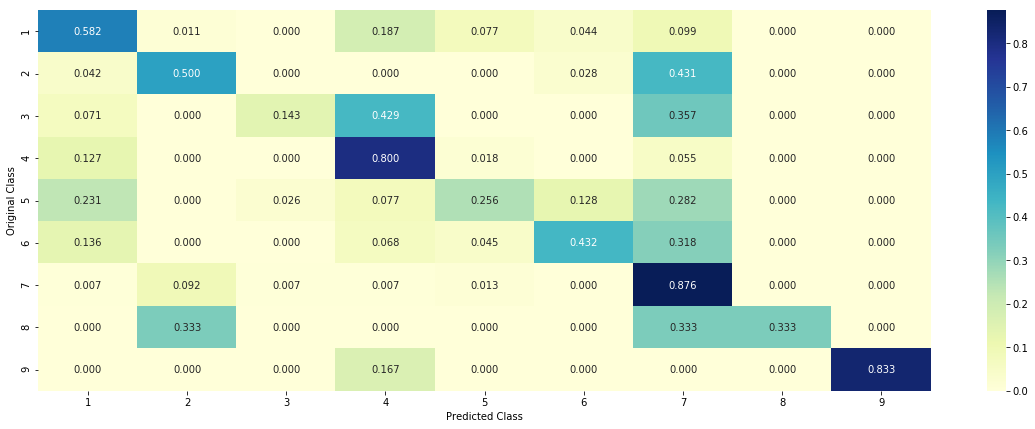

CPU times: user 24.2 s, sys: 11.9 s, total: 36 s
Wall time: 14.5 s


In [64]:
%%time

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

# `Project 003B - LogisticRegression-BoW(BIGRAM)`

In [66]:
%%time

# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer(ngram_range=(1,2))

train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

train_gene_feature_onehotCoding.shape, test_gene_feature_onehotCoding.shape, cv_gene_feature_onehotCoding.shape

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 22.9 ms


((2124, 229), (665, 229), (532, 229))

## `Strings to vectors conversion, Normalization and Stacking`

In [67]:
%%time

# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer(ngram_range=(1,2))

train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

train_variation_feature_onehotCoding.shape, test_variation_feature_onehotCoding.shape, cv_variation_feature_onehotCoding.shape

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 28.9 ms


((2124, 2085), (665, 2085), (532, 2085))

In [68]:
%%time

# building a BoWVectorizer with all the words.
text_vectorizer = CountVectorizer(ngram_range=(1,2))
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))
train_text_feature_onehotCoding.shape

Total number of unique words in train data : 2322774
CPU times: user 56 s, sys: 1.19 s, total: 57.1 s
Wall time: 57.1 s


(2124, 2322774)

In [69]:
%%time

#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)


CPU times: user 3min 2s, sys: 0 ns, total: 3min 2s
Wall time: 3min 2s


In [70]:
%%time

train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

CPU times: user 19.4 s, sys: 0 ns, total: 19.4 s
Wall time: 19.4 s


In [71]:
%%time

alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

CPU times: user 2min 19s, sys: 576 ms, total: 2min 19s
Wall time: 2min 17s


## `Stacking`

In [72]:
%%time

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

CPU times: user 988 ms, sys: 240 ms, total: 1.23 s
Wall time: 1.23 s


## `LR-BoW(BiGram) with class balancing`

for alpha = 1e-06
Log Loss : 1.5668246964230632
for alpha = 1e-05
Log Loss : 1.5454898811882813
for alpha = 0.0001
Log Loss : 1.4864613336151888
for alpha = 0.001
Log Loss : 1.268550796867237
for alpha = 0.01
Log Loss : 1.282405060623626
for alpha = 0.1
Log Loss : 1.3225100794144933
for alpha = 1
Log Loss : 1.3468882969635427
for alpha = 10
Log Loss : 1.3791156976397354
for alpha = 100
Log Loss : 1.3903217984734062


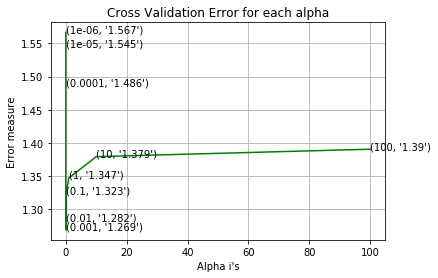

For values of best alpha =  0.001 The train log loss is: 0.6265912078607553
For values of best alpha =  0.001 The cross validation log loss is: 1.268550796867237
For values of best alpha =  0.001 The test log loss is: 1.2623973431951865
CPU times: user 29min 43s, sys: 2min 41s, total: 32min 25s
Wall time: 28min 36s


In [73]:
%%time
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

# `Optimal LR-BoW(BiGrams)Model`

Log loss : 1.268550796867237
Number of mis-classified points : 0.3966165413533835
-------------------- Confusion matrix --------------------


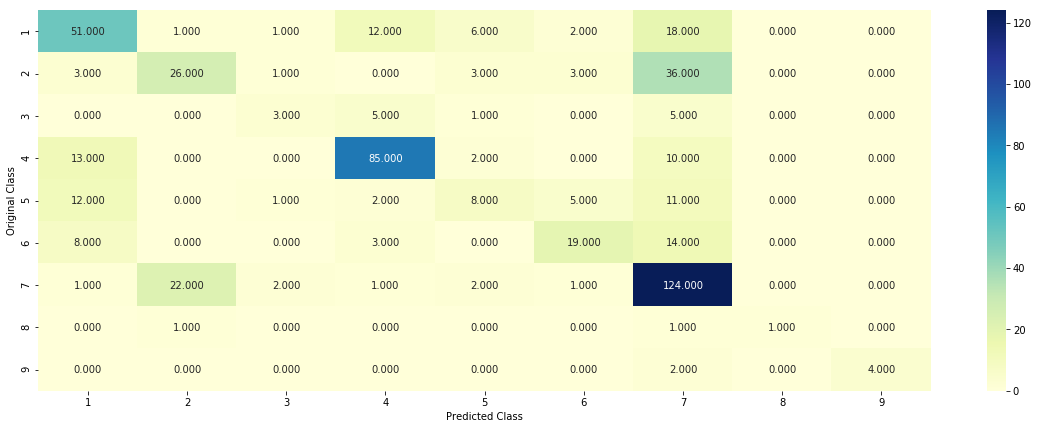

-------------------- Precision matrix (Columm Sum=1) --------------------


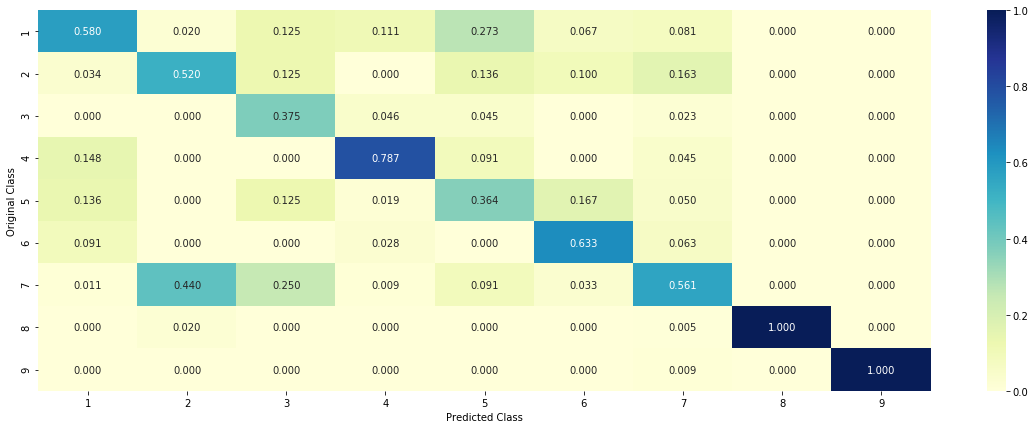

-------------------- Recall matrix (Row sum=1) --------------------


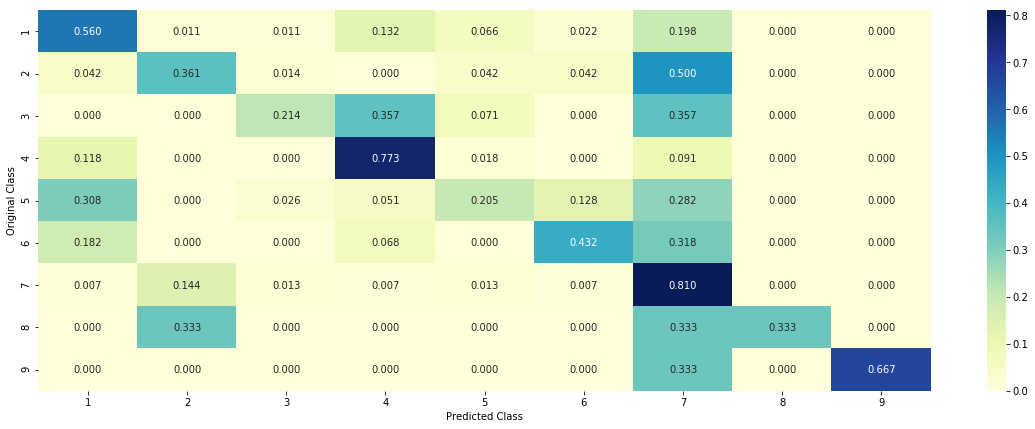

CPU times: user 5min 4s, sys: 17.9 s, total: 5min 22s
Wall time: 4min 57s


In [74]:
%%time

clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

# `Project 004 - Feature Engineering`

### `Creating new feature by summation of two univariate feature gene and variation`

In [96]:
train_df['featured'] = train_df.Gene + ' ' + train_df.Variation
cv_df['featured'] = cv_df.Gene + ' ' + cv_df.Variation
test_df['featured'] = test_df.Gene + ' ' + test_df.Variation

### `new feature conversion of vectors, normalization`

In [99]:
# one-hot encoding of new feature.
newfeat_vectorizer = CountVectorizer(ngram_range=(1,1))

train_new_feature_onehotCoding = newfeat_vectorizer.fit_transform(train_df['featured'])
test_new_feature_onehotCoding  = newfeat_vectorizer.transform(test_df['featured'])
cv_new_feature_onehotCoding    = newfeat_vectorizer.transform(cv_df['featured'])

#getting all the feature names (words)
train_text_features= newfeat_vectorizer.get_feature_names()
# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_new_feature_onehotCoding.sum(axis=0).A1
# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))

print("Total number of unique words in train data :", len(train_text_features))

#normalization:
train_new_feature_onehotCoding = normalize(train_new_feature_onehotCoding, axis=0)
test_new_feature_onehotCoding = normalize(test_new_feature_onehotCoding, axis=0)
cv_new_feature_onehotCoding = normalize(cv_new_feature_onehotCoding, axis=0)

Total number of unique words in train data : 2182


In [100]:
train_new_feature_onehotCoding.shape, cv_new_feature_onehotCoding.shape, test_new_feature_onehotCoding.shape

((2124, 2182), (532, 2182), (665, 2182))

In [101]:
train_x_onehotCoding = train_new_feature_onehotCoding
cv_x_onehotCoding = cv_new_feature_onehotCoding
test_x_onehotCoding = test_new_feature_onehotCoding

## `Linear SVM - BoW(Unigram) on new featured column`

for C = 1e-05
Log Loss : 1.3847935095593746
for C = 0.0001
Log Loss : 1.203292392160965
for C = 0.001
Log Loss : 1.19679191537085
for C = 0.01
Log Loss : 1.1891299246102909
for C = 0.1
Log Loss : 1.3787209639741351
for C = 1
Log Loss : 1.3787213952082422
for C = 10
Log Loss : 1.3787213543474985
for C = 100
Log Loss : 1.3804396477174612


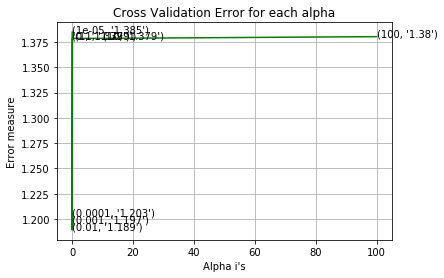

For values of best alpha =  0.01 The train log loss is: 0.2714246471036764
For values of best alpha =  0.01 The cross validation log loss is: 1.1891299246102909
For values of best alpha =  0.01 The test log loss is: 1.1847471354891055
CPU times: user 3.27 s, sys: 276 ms, total: 3.55 s
Wall time: 3.04 s


In [102]:
%%time

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

## `Optimal Linear SVM-BoW(Unigram) Model`

Log loss : 1.1891299246102909
Number of mis-classified points : 0.41541353383458646
-------------------- Confusion matrix --------------------


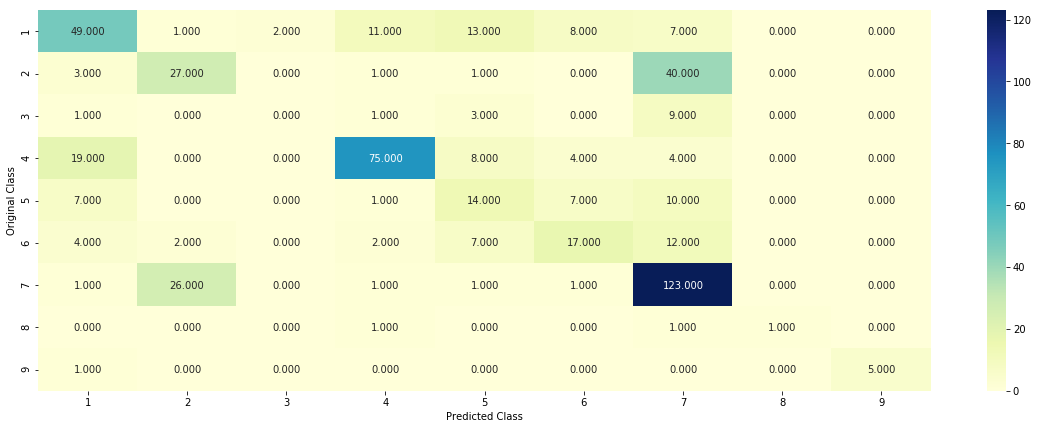

-------------------- Precision matrix (Columm Sum=1) --------------------


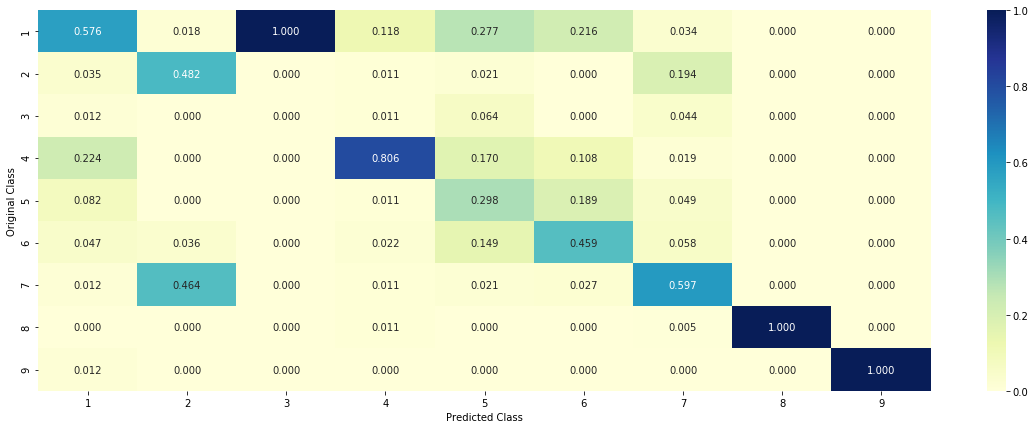

-------------------- Recall matrix (Row sum=1) --------------------


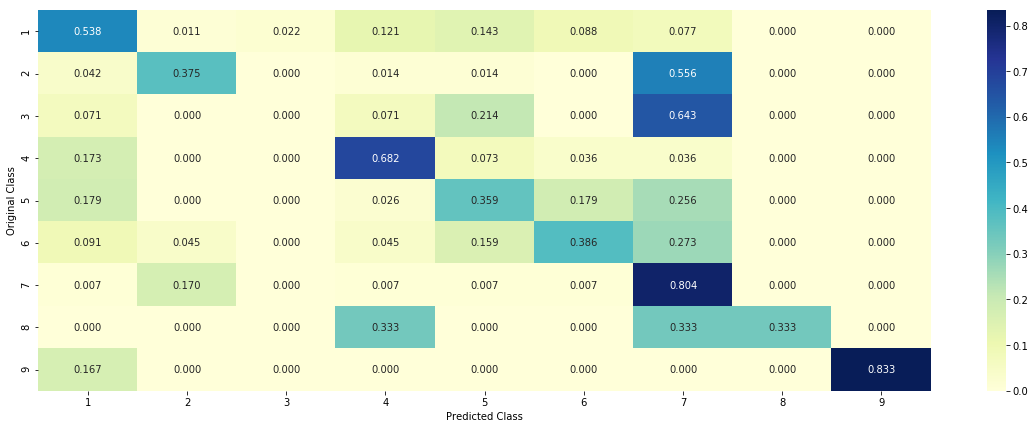

CPU times: user 3.74 s, sys: 1.55 s, total: 5.3 s
Wall time: 2.43 s


In [103]:
%%time

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

#### `FI(for correctly classified points)`

In [105]:
%%time

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['featured'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[0.0578 0.0312 0.0137 0.0175 0.1125 0.7433 0.0155 0.004  0.0046]]
Actual Class : 6
--------------------------------------------------
Out of the top  500  features  0 are present in query point
CPU times: user 10.8 s, sys: 0 ns, total: 10.8 s
Wall time: 10.8 s


In [107]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['featured'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 5
Predicted Class Probabilities: [[0.0604 0.0614 0.0181 0.0821 0.6307 0.0358 0.1009 0.0047 0.006 ]]
Actual Class : 1
--------------------------------------------------
Out of the top  500  features  0 are present in query point


## `consolidation and printing out accuracy and misclassification`

In [112]:
#!pip install xlrd
df = pd.read_excel('algo_val.xlsx')
df

Algorithm   LogLoss  Misclassification
0   LR-BoW(Unigram- without class balancing)  1.196606           0.345865
1      LR-BoW(Unigram- with class balancing)  1.195705           0.351504
2               SVM-Tfidf(Top 1000 Features)  1.151363           0.351804
3                        MaximumVoting-Tfidf  1.117031           0.353546
4                        Stacked-TFidf Model  1.142520           0.363383
5         KNN-TFidf model(Top 1000 Features)  1.064054           0.355263
6             LR-Tfidf(with class balancing)  1.160731           0.374060
7          LR-Tfidf(without class balancing)  1.181592           0.375940
8     MaximumVoting-TFidf(Top 1000 Features)  1.192573           0.377444
9                                  SVM-Tfidf  1.211156           0.377820
10         NB-Tfidf model(Top 1000 Features)  1.183052           0.381579
11    Stacked-TFidf Model(Top 1000 Features)  1.166674           0.389474
12                                 RF-TFidf   1.171457           0.392300
13                                 KNN-Tfidf  1.117596           0.390977
14                           LR-BoW(BiGrams)  1.268551           0.396617
15              RF-TFidf (Top 1000 Features)  1.169848           0.407895
16                                  NB-Tfidf  1.281028           0.413534
17                   Linear SVM-BoW(Unigram)  1.180000           0.415414
18   RF (Response Coding)(Top 1000 Features)  1.311738           0.437970
19                      RF (Response Coding)  1.294721           0.445489

# `Conclusion:`


`1. KNN-TFidf model(Top 1000 Features) was found to be having least log loss amongst other algorithms ~ 1.06`

`2. LR-BoW(Unigram- with class balancing) was found to be having least no of misclassifications amongst vectorizers ~ 35%`

`3. RF (Response Coding) was found to be having higest misclassification percentage ~ 45%`

`4. RF (Response Coding)(Top 1000 Features) was found to be having maximum log loss amogst other models ~ 1.311`